# Rucci Emanuele 2053183 - Elective in AI
Project description: create an efficient classifier based on autoencoder applied on EEG signal

https://github.com/syorami/Autoencoders-Variants/tree/master

https://github.com/alemme/pytorch-nnsae/blob/master/NNSAE.py

This file contains the set of experiments dedicated to the extracted features of the dataset: discard the information related to the trials and keep only the information related to the task (the movements performed by the subject).

In [ ]:
!pip install pytorch_lightning --quiet
!pip install wandb --quiet
!pip install pandas --quiet
!pip install numpy --quiet
!pip install scikit-learn --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet
!pip install info-nce-pytorch --quiet #https://github.com/RElbers/info-nce-pytorch

In [1]:
# Import
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, random_split
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import wandb
import pprint
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random
import torch.nn.functional as F
from info_nce import InfoNCE, info_nce

In [2]:
# Reproducibility
generator = torch.Generator()
generator.manual_seed(0)

In [3]:
# Constants
dataset_base_path = "Dataset/Extracted_features/"
project_base_path = "/"
dataset_path_list = [
    'dataset_task_1.csv', # Task 1
    'dataset_task_2.csv', # Task 2
    'dataset_task_3.csv', # Task 3
    'dataset_task_4.csv', # Task 4
]

In [4]:
batch_size = 32
window_size = 1 # size of the window to consider when selecting a sample, then a sample will be composed of window_size rows
enable_wandb = False

# Definition of an utity object that divides the dataset files according to the task they belong to
dataset_task_mapping = {}
dataset_task_mapping['task_1'] = []

# Task 1
task_1_file_index = [0]
for index in task_1_file_index:
    dict_file = {}
    dict_file['file_path'] = os.path.join(dataset_base_path, dataset_path_list[index])
    #file_name
    dict_file['file_name'] = dataset_path_list[index].split("/")[-1]
    #remove the extension
    dict_file['file_name'] = dict_file['file_name'].split(".")[0]
    dataset_task_mapping['task_1'].append(dict_file)

# Task 2
dataset_task_mapping['task_2'] = []
task_2_file_index = [1]
for index in task_2_file_index:
    dict_file = {}
    dict_file['file_path'] = os.path.join(dataset_base_path, dataset_path_list[index])
    dict_file['file_name'] = dataset_path_list[index].split("/")[-1]
    dict_file['file_name'] = dict_file['file_name'].split(".")[0]
    dataset_task_mapping['task_2'].append(dict_file)

# Task 3
dataset_task_mapping['task_3'] = []
task_3_file_index = [2]
for index in task_3_file_index:
    dict_file = {}
    dict_file['file_path'] = os.path.join(dataset_base_path, dataset_path_list[index])
    dict_file['file_name'] = dataset_path_list[index].split("/")[-1]
    dict_file['file_name'] = dict_file['file_name'].split(".")[0]
    dataset_task_mapping['task_3'].append(dict_file)

# Task 4
dataset_task_mapping['task_4'] = []
task_4_file_index = [3]
for index in task_4_file_index:
    dict_file = {}
    dict_file['file_path'] = os.path.join(dataset_base_path, dataset_path_list[index])
    dict_file['file_name'] = dataset_path_list[index].split("/")[-1]
    dict_file['file_name'] = dict_file['file_name'].split(".")[0]
    dataset_task_mapping['task_4'].append(dict_file)

# Approach 2
This is to address the study: "**Observe the performance of a general model that can be used to identify states across all the tasks.**"



## Dataset

In [27]:
class DatasetApproach2(Dataset):
  def __init__(self, window_size=1):
    self.dataset = pd.DataFrame()

    # Create a unique dataframe that is composed by the concatenation of all the files that belong to the task
    tasks_name = ['task_1','task_2','task_3','task_4']
    for task_name in tasks_name:
      for file in dataset_task_mapping[task_name]:
        df = pd.read_csv(file['file_path'])
        # Concatenate the dataframes by rows but remove the first row
        df = df.iloc[1:]
        self.dataset = pd.concat([self.dataset, df], ignore_index=True)

    print(f"Concatenating the dataframes ({len(self.dataset)})")
    print(f"Dataset shape: {self.dataset.shape}")

    # Windowing
    self.window_size = window_size

  def __len__(self):
    return len(self.dataset) - self.window_size

  def __getitem__(self, idx):
    # return as a tensor
    print(f"Index: {idx}")
    return torch.tensor(self.dataset.iloc[idx].values)

  def get_dataframe(self):
    return self.dataset

In [28]:
dataset = DatasetApproach2()

Concatenating the dataframes (1953)
Dataset shape: (1953, 71)


In [29]:
dataset = DatasetApproach2()
print(f"Dataset length: {len(dataset)}, Number of files used (Task 1: {len(dataset_task_mapping['task_1'])} + Task 2: {len(dataset_task_mapping['task_2'])} + Task 3: {len(dataset_task_mapping['task_3'])} + Task 4: {len(dataset_task_mapping['task_4'])})")
# Unique values of the labels from the last column of the dataset
print(f"Unique values of the labels: {dataset.get_dataframe().iloc[:,-1].unique()}")

# Shuffle the rows of the dataset using sklearn (making sure the shuffle is reproducible)
from sklearn.utils import shuffle
data = shuffle(dataset.get_dataframe(), random_state=0)
# Remove the index column
data = data.reset_index(drop=True)

# Splitting into train and test sets (80% training data, 20% testing data)
train_df, test_df = train_test_split(data, test_size=0.15, random_state=42)

# Splitting the train_df further into train and validation sets (70% training data, 30% validation data)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)

print(f"Data: {len(data)} ,Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")


#Create the Dataframe classe Approach 2
class DataFrameApproach2(Dataset):
    def __init__(self, dataframe, selected_columns=None):
        # Set as data the columns from the parameter selected_columns if are passed, otherwise set all the columns except the last one
        if selected_columns:
            self.data = dataframe.iloc[:, selected_columns].values
        else:
            self.data = dataframe.iloc[:, :-1].values

        self.targets = dataframe.iloc[:, -1].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx])
        y = self.targets[idx]
        return x, y

def collate_fn(batch):
    data = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Apply min-max normalization to each column
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)

    return torch.tensor(normalized_data), targets

# Creating datasets and data loaders for each split
selected_columns = [17,18,19,52,53,54]
train_dataset = DataFrameApproach2(train_df, selected_columns)
val_dataset = DataFrameApproach2(val_df, selected_columns)
test_dataset = DataFrameApproach2(test_df, selected_columns)

Concatenating the dataframes (1953)
Dataset shape: (1953, 71)
Dataset length: 1952, Number of files used (Task 1: 1 + Task 2: 1 + Task 3: 1 + Task 4: 1)
Unique values of the labels: [1 2 3 4]
Data: 1953 ,Train size: 1411, Val size: 249, Test size: 293


## AutoEncoder Model

### Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, window_size = 1, enable_sparsity_loss=False):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
        )

        # Apply He initialization to the linear layers
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        batch_size, input_dim = x.size()  # Obtain the shape of the input [bs, input_dim]
        input = x
        x = self.encoder(input)
        return x

### Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_dim, window_size, enable_sparsity_loss=False):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Linear(256, window_size * input_dim),
            nn.Sigmoid()
        )

        # Apply He initialization to the linear layers
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        # x = x.to(torch.float32)
        x = self.decoder(x)
        return x

### AE Lightning Module ⚡️⚡️

In [ ]:
class Autoencoder(LightningModule):
    def __init__(self, input_dim, batch_size, sparsity_factor=0.1, sparsity_loss_coef = 1e-3, weight_decay=0.001, window_size=window_size, enable_sparsity_loss=False, enable_weight_decay_loss=False ,enable_non_negativity_constraint=False,enable_wandb = False):
        super(Autoencoder, self).__init__()

        if( enable_sparsity_loss == True and enable_non_negativity_constraint== True):
          print("The combination of constraints enable_sparsity_loss and enable_non_negativity_constraint both true leads to error in to the model matrix multiplication. This will be solved by setting enable_non_negativity_constraint to False.")

        self.save_hyperparameters()
        self.encoder = Encoder(input_dim=input_dim, window_size=window_size, enable_sparsity_loss = enable_sparsity_loss)
        self.decoder = Decoder(input_dim=input_dim, window_size=window_size, enable_sparsity_loss = enable_sparsity_loss)
        self.train_loss_memory = []
        self.train_rec_loss_memory = []

        self.val_loss_memory = []
        self.val_rec_loss_memory = []

        self.test_loss_memory = []
        self.test_rec_loss_memory = []

        self.batch_size = batch_size



        # --- Loss Settings
        self.enable_sparsity_loss = enable_sparsity_loss
        if enable_sparsity_loss:
          self.sparsity_loss_coef = sparsity_loss_coef
          self.sparsity_factor = sparsity_factor
          print(f"Enabled Sparsity term in the loss with sparsity loss coeff => {self.sparsity_loss_coef} and sparsity factor=>{self.sparsity_factor}")

          # self.sparsity_loss = nn.KLDivLoss(reduction='batchmean')
          # Memory logs for sparsity
          self.train_sparsity_loss_memory = []
          self.val_sparsity_loss_memory = []
          self.test_sparsity_loss_memory = []

          self.enable_non_negativity_constraint = False
        else:
          self.enable_non_negativity_constraint = enable_non_negativity_constraint
          if enable_non_negativity_constraint:
            print("Enabled non negativity constraint")


        self.enable_weight_decay_loss = enable_weight_decay_loss
        if enable_weight_decay_loss:
          print("Enabled weight decay")
          self.weight_decay = weight_decay

        self.wandb_log = enable_wandb

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if torch.cuda.is_available():
            if torch.cuda.device_count() > 1:
                device = torch.device('cuda:0')
                print('Using device:', device)
            else:
                device = torch.device('cuda')
                print('Using device:', device)
        else:
            device = torch.device('cpu')
            print('Using device:', device)


        print('Using device:', device)

        self.to(device)
        print(f"Initialized Model on {self.device}")

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def kl_div(self, p, p_hat):
      funcs = nn.Sigmoid()
      p_hat = torch.mean(funcs(p_hat), 1)
      p_tensor = torch.Tensor([p] * p_hat.shape[0]).to(self.device)


      return torch.sum(p_tensor * torch.log(p_tensor) - p_tensor * torch.log(p_hat) + (1 - p_tensor) * torch.log(1 - p_tensor) - (1 - p_tensor) * torch.log(1 - p_hat))

    def sparse_loss(self, values):
      loss = 0
      values = values.view(self.batch_size, -1)

      # Encoder sparsity
      lyrs_encoder = list(self.encoder.encoder.children())
      for i, lyr in enumerate(lyrs_encoder):
          if isinstance(lyr, nn.Linear):
            values = lyr(values)
            # loss += self.sparsity_loss(torch.tensor([self.sparsity_factor]).to(self.device), values.to(self.device))
            loss += self.kl_div(self.sparsity_factor, values.to(self.device))

      # Decoder sparsity
      lyrs_decoder = list(self.decoder.decoder.children())
      for i, lyr in enumerate(lyrs_decoder):
          if isinstance(lyr, nn.Linear):
              values = lyr(values)
              # loss += self.sparsity_loss(torch.tensor([self.sparsity_factor]).to(self.device), values.to(self.device))
              loss += self.kl_div(self.sparsity_factor, values.to(self.device))

      return loss

    def calculate_weight_decay_loss(self):
        weight_decay_loss = 0.0
        for param in self.parameters():
            weight_decay_loss += 0.5 * self.weight_decay * torch.norm(param, p=2) ** 2
        return weight_decay_loss

    def enforce_non_negativity(self):
      for param in self.parameters():
        param.data.clamp_(min=0, max=None)

    def training_step(self, batch, batch_idx):
        x = batch[0].to(torch.float32) #[bs, input_dim]
        _, reconstructions = self(x)

        x = x.view(-1) # [bs * input_dim]
        reconstructions = reconstructions.view(-1)

        loss_mse = nn.MSELoss()(reconstructions, x)
        loss = loss_mse

        if self.enable_sparsity_loss:
          # sparsity_loss = self.sparsity_loss(torch.log(reconstructions).to(self.device), torch.tensor([self.sparsity_factor]).to(self.device))
          sparsity_loss = self.sparse_loss(x) * self.sparsity_loss_coef
          loss += sparsity_loss
          self.train_sparsity_loss_memory.append(sparsity_loss)

        if self.enable_weight_decay_loss:
          weight_decay_loss = self.calculate_weight_decay_loss()
          loss += weight_decay_loss

        self.train_loss_memory.append(loss)
        self.train_rec_loss_memory.append(loss_mse)

        if self.wandb_log:
          wandb.log({"train_total_loss": loss})
          wandb.log({"train_reconstruction_loss": loss_mse})

        return loss

    def validation_step(self, batch, batch_idx):
      x = batch[0].to(torch.float32)
      _, reconstructions = self(x)

      x = x.view(-1) #[]
      reconstructions = reconstructions.view(-1)

      loss_mse = nn.MSELoss()(reconstructions, x)
      # For early stop and Model checkpoint callbacks
      self.log("val_reconstruction_loss",loss_mse)
      
      
      
      loss = loss_mse

      if self.enable_sparsity_loss:
        # sparsity_loss = self.sparsity_loss(torch.log(reconstructions).to(self.device), torch.tensor([self.sparsity_factor]).to(self.device))
        sparsity_loss = self.sparse_loss(x) * self.sparsity_loss_coef
        loss += sparsity_loss
        self.val_sparsity_loss_memory.append(sparsity_loss)

      if self.enable_weight_decay_loss:
        weight_decay_loss = self.calculate_weight_decay_loss()
        loss += weight_decay_loss

      if self.enable_non_negativity_constraint:
        self.enforce_non_negativity()


      self.val_loss_memory.append(loss)
      self.val_rec_loss_memory.append(loss_mse)
      

      if self.wandb_log:
        wandb.log({"val_total_loss": loss})
        wandb.log({"val_reconstruction_loss": loss_mse})

      return loss

    def test_step(self, batch, batch_idx):
      x = batch[0].to(torch.float32)
      _, reconstructions = self(x)

      x = x.view(-1) #[]
      reconstructions = reconstructions.view(-1)

      loss_mse = nn.MSELoss()(reconstructions, x)
      loss = loss_mse

      if self.enable_sparsity_loss:
        # sparsity_loss = self.sparsity_loss(torch.log(reconstructions).to(self.device), torch.tensor([self.sparsity_factor]).to(self.device))
        sparsity_loss = self.sparse_loss(x) * self.sparsity_loss_coef
        loss += sparsity_loss
        self.test_sparsity_loss_memory.append(sparsity_loss)

      if self.enable_weight_decay_loss:
        weight_decay_loss = self.calculate_weight_decay_loss()
        loss += weight_decay_loss

      if self.enable_non_negativity_constraint:
        self.enforce_non_negativity()

      self.test_loss_memory.append(loss)
      self.test_rec_loss_memory.append(loss_mse)


      return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        scheduler = CosineAnnealingLR(optimizer, T_max=10)  # Adjust T_max as needed

        return {'optimizer': optimizer, 'lr_scheduler': {'scheduler': scheduler, 'interval': 'epoch'}}

    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_closure):
        # step
        optimizer.step(closure=optimizer_closure)

        if self.enable_non_negativity_constraint:
          self.enforce_non_negativity()

    def on_epoch_end(self):
        if self.wandb_log:
            wandb.log({'epoch': self.current_epoch})

    def on_train_epoch_end(self):
        # Access the training loss from the outputs
        train_loss = torch.stack([x for x in self.train_loss_memory]).mean()
        train_rec_loss = torch.stack([x for x in self.train_rec_loss_memory]).mean()

        # Print the training loss
        print_log = f'Training Loss - Epoch {self.current_epoch}: Total Loss => {train_loss.item()} MSE => {train_rec_loss}'

        self.train_loss_memory.clear()
        self.train_rec_loss_memory.clear()

        if self.enable_sparsity_loss:
          train_sparsity_loss = torch.stack([x for x in self.train_sparsity_loss_memory]).mean()
          print_log += f' SPARSE => {train_sparsity_loss}'
          self.train_sparsity_loss_memory.clear()

        if self.wandb_log:
          wandb.log({"train_total_loss": train_loss})
          wandb.log({"train_reconstruction_loss": train_rec_loss})
          if self.enable_sparsity_loss:
            wandb.log({"train_sparse_loss": train_sparsity_loss})

        print(print_log)

    def on_validation_epoch_end(self):
        # Access the training loss from the outputs
        val_loss = torch.stack([x for x in self.val_loss_memory]).mean()
        val_rec_loss = torch.stack([x for x in self.val_rec_loss_memory]).mean()

        # Print the training loss
        print_log = f'Validation Loss - Epoch {self.current_epoch}: Total Loss => {val_loss.item()} MSE => {val_rec_loss}'

        self.val_loss_memory.clear()
        self.val_rec_loss_memory.clear()

        if self.enable_sparsity_loss:
          val_sparsity_loss = torch.stack([x for x in self.val_sparsity_loss_memory]).mean()
          print_log += f' SPARSE => {val_sparsity_loss}'
          self.val_sparsity_loss_memory.clear()

        if self.wandb_log:
          wandb.log({"val_total_loss": val_loss})
          wandb.log({"val_reconstruction_loss": val_rec_loss})
          if self.enable_sparsity_loss:
            wandb.log({"val_sparse_loss": val_sparsity_loss})

        print(print_log)

    def on_test_epoch_end(self):
        # Access the training loss from the outputs
        test_loss = torch.stack([x for x in self.test_loss_memory]).mean()
        test_rec_loss = torch.stack([x for x in self.test_rec_loss_memory]).mean()

        # Print the training loss
        print_log = f'Test Loss - Epoch {self.current_epoch}: Total Loss => {test_loss.item()} MSE => {test_rec_loss}'

        self.test_loss_memory.clear()
        self.test_rec_loss_memory.clear()

        if self.enable_sparsity_loss:
          test_sparsity_loss = torch.stack([x for x in self.test_sparsity_loss_memory]).mean()
          print_log += f' SPARSE => {test_sparsity_loss}'
          self.test_sparsity_loss_memory.clear()

        if self.wandb_log:
          wandb.log({"test_total_loss": test_loss})
          wandb.log({"test_reconstruction_loss": test_rec_loss})
          if self.enable_sparsity_loss:
            wandb.log({"test_sparse_loss": test_sparsity_loss})

        self.test_rec_loss = test_rec_loss

        print(print_log)

## Training: HPO with Wandb Sweeps 🔎🔎

In [ ]:
# WANDB Sweep for HPO
sweep_config = {
    'method': 'bayes'
}
metric = {
  'name': 'val_reconstruction_loss',
  'goal': 'minimize'
}
sweep_config['metric'] = metric
sweep_config['group'] = "approach_2_AutoEncoder_FeaturesDataset"
parameters_dict = {
    'batch_size': {
          'values': [64,128,256,512]
        },
    'epochs': {
          'values': [1000]
        },
    'sparsity_factor': {
        'values': [0.1, 0.05, 0.005]
      },
    'wdecay_loss':{
        'values': [True,False]
      },
    'sparsity_loss':{
        'values': [True,False]
      },
    'non_negative_constraint':{
        'values': [True,False]
      }
}

sweep_config['parameters'] = parameters_dict

#Create the sweep
sweep_id = wandb.sweep(sweep_config,entity="rucci-2053183", project="Project_EAI_BrainComputerInterface")

In [ ]:
i=0

def train(config=None):
  global i
  with wandb.init(config=config):
    i = i + 1
    config = wandb.config
    # access to the current attempt number from wandb
    print(f"Attempt number: {wandb.run.id}")
    if config.sparsity_loss == True and config.non_negative_constraint == True:
      print(f"Skipping following config becouse not supported combination sparsity_loss =>{config.sparsity_loss}, non_negative_constraint =>{config.non_negative_constraint}")
      print(f"Config ==>{config}")
    else:
      # bs given by the agent
      train_dataset = DataFrameApproach2(train_df)
      val_dataset = DataFrameApproach2(val_df)
      test_dataset = DataFrameApproach2(test_df)
      train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
      val_loader = DataLoader(val_dataset, batch_size=config.batch_size,shuffle=False, collate_fn=collate_fn, drop_last=True)
      test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)

      batch = next(iter(train_loader))
      input_dim = batch[0].shape[-1]

      # Model
      model = Autoencoder(input_dim=input_dim, batch_size = config.batch_size,sparsity_factor=config.sparsity_factor ,enable_sparsity_loss=config.sparsity_loss, enable_weight_decay_loss=config.wdecay_loss, enable_non_negativity_constraint=config.non_negative_constraint, enable_wandb = True)
      early_stop = EarlyStopping(monitor="val_reconstruction_loss", mode="min", check_on_train_epoch_end=False)


      # Define the ModelCheckpoint callback to save the best model
      checkpoint_callback = ModelCheckpoint(
          dirpath="saved_models/Approach_2_FeaturesDataset/ae/"+str(i)+"/",
          filename="best_model",
          monitor="val_reconstruction_loss",
          mode="min",
          save_top_k=2,
          save_last=True,
          verbose=False,
      )

      trainer = Trainer(max_epochs=config.epochs, default_root_dir="saved_models/Approach_2_FeaturesDataset/ae/"+str(i)+"/", callbacks=[early_stop, checkpoint_callback],fast_dev_run=False)
      trainer.fit(model, train_loader, val_loader)
      trainer.test(model, test_loader)


wandb.agent(sweep_id, train, count=10)

## Evaluation of the BEST AE on test set

In [ ]:
batch_size = 64
train_dataset = DataFrameApproach2(train_df)
val_dataset = DataFrameApproach2(val_df)
test_dataset = DataFrameApproach2(test_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False, collate_fn=collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)
batch = next(iter(test_loader))

In [ ]:
base_model_dir = "saved_models/Approach_2_FeaturesDataset/ae/"
model_to_test_paths = [
    "1/last.ckpt",
    "1/best_model.ckpt",
    "1/best_model-v1.ckpt",
    "5/last.ckpt",
    "5/best_model-v1.ckpt",
    "5/best_model.ckpt",
    "6/last.ckpt",
    "7/last.ckpt",
    "7/best_model.ckpt",
    "7/best_model-v1.ckpt",
    "9/last.ckpt",
    "9/best_model.ckpt",
    "9/best_model-v1.ckpt",
    "10/last.ckpt",
    "10/best_model.ckpt",
    "10/best_model-v1.ckpt",
]
      
# Test the models
print(f"Models to test: {model_to_test_paths}")


best_metric = 1000000000
best_model = ""
for model_path_ in model_to_test_paths:
  version = model_path_
  model_path = base_model_dir+model_path_
  input_dim = batch[0].shape[-1]

  checkpoint_model = Autoencoder(input_dim=input_dim, batch_size = batch_size,sparsity_factor=0.005,enable_sparsity_loss=False, enable_weight_decay_loss=False, enable_non_negativity_constraint=False, enable_wandb = False)

  checkpoint_model.load_state_dict(torch.load(model_path, map_location=checkpoint_model.device)['state_dict']) # ------> PyTorch Lightning API

  trainer = Trainer(accelerator = 'auto', fast_dev_run=False)
  print(f"Evaluation => {version}")
  trainer.test(checkpoint_model, dataloaders=test_loader)

  if(checkpoint_model.test_rec_loss < best_metric):
    best_metric = checkpoint_model.test_rec_loss
    best_model = version

In [ ]:
print(f"BEST MODEL => FILE = {best_model}, MSE = {best_metric}")

## Classifier Model
The same classifier model used in the previous experiments is used here the only difference is the dataset, here we use the extracted features dataset.

In [33]:
# First create a mapping utility to go from label to idx and vice versa
label2idx= {}
idx2label = {}
labels_task = dataset.get_dataframe()['labels'].unique()

for i in range(len(labels_task)):
  label2idx[labels_task[i]] = i
  idx2label[str(i)] = labels_task[i]

In [34]:
class ClassifierPerTask_Approach2(LightningModule):
    def __init__(self, encoder, text_labels, head_type=1, enable_wandb=False):
        super(ClassifierPerTask_Approach2, self).__init__()
        self.save_hyperparameters()

        self.encoder = encoder
        self.text_labels = text_labels
        if(head_type==1):
          # HEAD 1
          self.classifier = nn.Sequential(
              nn.Linear(encoder.z_dim, 128),
              nn.ReLU(),
              nn.Linear(128, len(text_labels))
          )
        elif (head_type ==2):
          # HEAD 2
          self.classifier = nn.Sequential(
              nn.Linear(encoder.z_dim, 256),
              nn.ReLU(),
               nn.Dropout(0.2),
              nn.Linear(256, 128),
              nn.ReLU(),
              nn.Dropout(0.2),
              nn.Linear(128, len(text_labels))
          )
        elif (head_type ==3):
          # HEAD 3
          self.classifier = nn.Sequential(
              nn.Linear(encoder.z_dim, 256),
              nn.BatchNorm1d(256),  # Batch normalization
              nn.ReLU(),
              nn.Dropout(0.2),
              nn.Linear(256, 128),
              nn.BatchNorm1d(128),  # Batch normalization
               nn.ReLU(),
              nn.Dropout(0.2),
              nn.Linear(128, len(text_labels))
          )
        else:
          # HEAD 4
          self.classifier = nn.Sequential(
              nn.Linear(encoder.z_dim, 256),
              nn.LayerNorm(256),  # Apply layer normalization
              nn.ReLU(),
              nn.Dropout(0.2),
              nn.Linear(256, 128),
              nn.LayerNorm(128),  # Apply layer normalization
              nn.ReLU(),
              nn.Dropout(0.2),
              nn.Linear(128, len(text_labels))
          )

        self.train_loss = []
        self.train_accuracy = []
        self.val_loss = []
        self.val_accuracy = []
        self.test_loss = []
        self.test_accuracy = []

        self.enable_wandb = enable_wandb

        if self.enable_wandb:
          wandb.init(project="Project_EAI_BrainComputerInterface", entity="rucci-2053183", group="approach2_classifier")

    def forward(self, z):
        return self.classifier(z)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs = inputs.to(torch.float32)
        z = self.encoder(inputs)
        outputs = self(z)
        labels = self.labels2TargetTensor(labels).to(torch.long).to(outputs.device)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log('train_loss', loss)
        self.log('test_accuracy', acc)

        self.train_loss.append(loss)
        self.train_accuracy.append(acc)

        return loss

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs = inputs.to(torch.float32)
        z = self.encoder(inputs)
        outputs = self(z)
        labels = self.labels2TargetTensor(labels).to(torch.long).to(outputs.device)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log('test_loss', loss)
        self.log('test_accuracy', acc)

        self.test_loss.append(loss)
        self.test_accuracy.append(acc)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs = inputs.to(torch.float32)
        z = self.encoder(inputs)
        outputs = self(z)
        labels = self.labels2TargetTensor(labels).to(torch.long).to(outputs.device)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log('val_loss', loss)
        self.log('val_accuracy', acc)

        self.val_loss.append(loss)
        self.val_accuracy.append(acc)

        return loss

    def configure_optimizers(self):
      optimizer = optim.Adam(self.parameters(), lr=0.001)
      scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
      return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def labels2TargetTensor(self, labels):
      target = []
      for item in labels:
        target.append(label2idx[item])

      return torch.Tensor(target)

    def on_train_epoch_end(self):
        train_loss = torch.stack([x for x in self.train_loss]).mean()
        train_acc = torch.stack([x for x in self.train_accuracy]).mean()

        # Print the training loss
        print_log = f'Training - Epoch {self.current_epoch}: Loss => {train_loss.item()} ACCURACY => {train_acc}'

        self.train_loss.clear()
        self.train_accuracy.clear()

        if self.enable_wandb:
            # Log mean training loss
            wandb.log({"epoch_train_loss": train_loss, "epoch_train_accuracy": train_acc})

        print(print_log)

    def on_test_epoch_end(self):
        test_loss = torch.stack([x for x in self.test_loss]).mean()
        test_acc = torch.stack([x for x in self.test_accuracy]).mean()

        # Print the training loss
        print_log = f'Test - Epoch {self.current_epoch}: Loss => {test_loss.item()} ACCURACY => {test_acc}'

        self.test_loss.clear()
        self.test_accuracy.clear()

        if self.enable_wandb:
            # Log mean test loss and accuracy
            wandb.log({"epoch_test_loss": test_loss, "epoch_test_accuracy": test_acc})

        print(print_log)

        self.test_acc = test_acc

    def on_validation_epoch_end(self):
        val_loss = torch.stack([x for x in self.val_loss]).mean()
        val_acc = torch.stack([x for x in self.val_accuracy]).mean()

        # Print the training loss
        print_log = f'Validation - Epoch {self.current_epoch}: Loss => {val_loss.item()} ACCURACY => {val_acc}'

        self.val_loss.clear()
        self.val_accuracy.clear()
        self.log("epoch_val_accuracy", val_acc)
        if self.enable_wandb:
            # Log mean validation loss and accuracy
            wandb.log({"epoch_val_loss": val_loss, "epoch_val_accuracy": val_acc})
            wandb.log({"epoch": self.current_epoch})

        print(print_log)

## ⚡️ Train the Classifier ⚡️

In [ ]:
batch_size = 64
train_dataset = DataFrameApproach2(train_df)
val_dataset = DataFrameApproach2(val_df)
test_dataset = DataFrameApproach2(test_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False, collate_fn=collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)

In [ ]:
# Import the best AE
base_model_dir = "saved_models/Approach_2_FeaturesDataset"
best_model_path = base_model_dir+"/ae/6/last.ckpt"


batch = next(iter(train_loader))
input_dim = batch[0].shape[-1]
checkpoint_model = Autoencoder(input_dim=input_dim, batch_size = batch_size,sparsity_factor=0.005,enable_sparsity_loss=False, enable_weight_decay_loss=False, enable_non_negativity_constraint=False, enable_wandb = False)
checkpoint_model.load_state_dict(torch.load(best_model_path, map_location=checkpoint_model.device)['state_dict']) # ------> PyTorch Lightning API

In [ ]:
# Initialize the Classifier Module for training
encoder = checkpoint_model.encoder
encoder.z_dim = 128
classifier = ClassifierPerTask_Approach2(encoder, labels_task,head_type=4, enable_wandb=True)

early_stop = EarlyStopping(monitor="epoch_val_accuracy", min_delta=0.00, patience=30, verbose=True, mode="max")
checkpoint_callback = ModelCheckpoint(
     monitor='epoch_val_accuracy',
     dirpath="saved_models/Approach_2_FeaturesDataset/classifier/",
     filename='approach2-featsDataset-epoch{epoch:02d}',
     auto_insert_metric_name=True,
     mode="max",
     save_top_k=2,
     verbose=True
)

trainer_classifier = Trainer(max_epochs=100, default_root_dir="saved_models/Approach_2_FeaturesDataset/classifier/", callbacks=[early_stop,checkpoint_callback],fast_dev_run=False)
trainer_classifier.fit(classifier, train_loader, val_loader)
# trainer.test(classifier, test_loader)

## Evaluation of the Classifier on test set

In [30]:
batch_size = 64
train_dataset = DataFrameApproach2(train_df)
val_dataset = DataFrameApproach2(val_df)
test_dataset = DataFrameApproach2(test_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False, collate_fn=collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)
batch = next(iter(test_loader))

In [31]:
# Import the best AE
base_model_dir = "saved_models/Approach_2_FeaturesDataset"
best_model_path = base_model_dir+"/ae/6/last.ckpt"

batch = next(iter(train_loader))
input_dim = batch[0].shape[-1]
checkpoint_model = Autoencoder(input_dim=input_dim, batch_size = batch_size,sparsity_factor=0.005,enable_sparsity_loss=False, enable_weight_decay_loss=False, enable_non_negativity_constraint=False, enable_wandb = False)
checkpoint_model.load_state_dict(torch.load(best_model_path, map_location=checkpoint_model.device)['state_dict']) # ------> PyTorch Lightning API

Using device: cpu
Using device: cpu
Initialized Model on cpu


<All keys matched successfully>

In [35]:
base_model_dir = "saved_models/Approach_2_FeaturesDataset/classifier/"
model_to_test_paths = [
    "/Head1/approach2-featsDataset-epochepoch=11.ckpt",
    "/Head1/approach2-featsDataset-epochepoch=38.ckpt",
    "/Head3/approach2-featsDataset-epochepoch=25.ckpt",
    "/Head3/approach2-featsDataset-epochepoch=33.ckpt",
]

best_metric = 0
best_model = ""
for model_path_ in model_to_test_paths:
  version = model_path_
  head_type = int(model_path_.split("/")[1][-1])
  model_path = base_model_dir+model_path_
  input_dim = batch[0].shape[-1]

  checkpoint_model = ClassifierPerTask_Approach2(encoder, labels_task, head_type=head_type, enable_wandb=False)

  print(f"Loading {model_path_} {head_type}")
  checkpoint_model.load_state_dict(torch.load(model_path, map_location=checkpoint_model.device)['state_dict']) # ------> PyTorch Lightning API

  trainer = Trainer(accelerator = 'auto', fast_dev_run=False)
  print(f"Evaluation => {version}")
  trainer.test(checkpoint_model, dataloaders=test_loader)

  if(checkpoint_model.test_acc > best_metric):
    best_metric = checkpoint_model.test_acc
    best_model = version

/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loading /Head1/approach2-featsDataset-epochepoch=11.ckpt 1
Evaluation => /Head1/approach2-featsDataset-epochepoch=11.ckpt


/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 52.54it/s] 

/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Test - Epoch 0: Loss => 0.9570581316947937 ACCURACY => 0.6484375
Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy              0.6484375
        test_loss           0.9570581316947937
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loading /Head1/approach2-featsDataset-epochepoch=38.ckpt 1
Evaluation => /Head1/approach2-featsDataset-epochepoch=38.ckpt


/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00,  8.78it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy              0.6328125
        test_loss           0.9763163924217224
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loading /Head3/approach2-featsDataset-epochepoch=25.ckpt 3
Evaluation => /Head3/approach2-featsDataset-epochepoch=25.ckpt


/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 167.01it/s]Test - Epoch 0: Loss => 0.9083847999572754 ACCURACY => 0.66796875


/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loading /Head3/approach2-featsDataset-epochepoch=33.ckpt 3
Evaluation => /Head3/approach2-featsDataset-epochepoch=33.ckpt


/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00,  8.86it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy              0.6640625
        test_loss           0.9047603607177734
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [36]:
print(f"BEST MODEL => FILE = {best_model}, MSE = {best_metric}")

BEST MODEL => FILE = /Head3/approach2-featsDataset-epochepoch=25.ckpt, MSE = 0.66796875


### Confusion Matrix


/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.


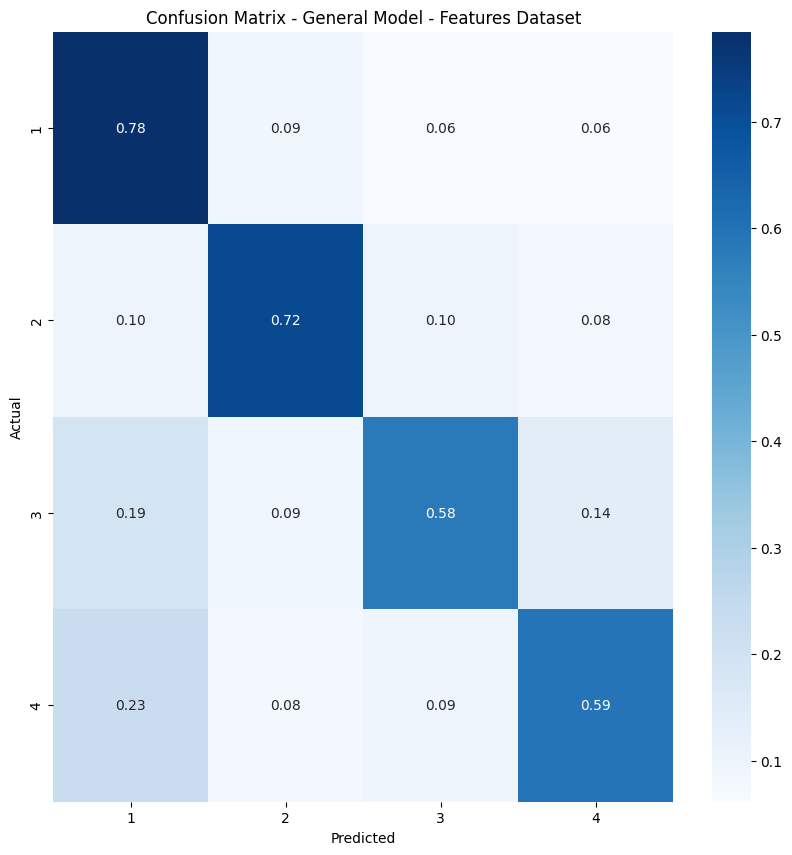

In [37]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

# Import the best Classifier model
model_path = base_model_dir+"/"+best_model
input_dim = batch[0].shape[-1]
checkpoint_model = ClassifierPerTask_Approach2.load_from_checkpoint(model_path, head_type=3, enable_wandb=False)
checkpoint_model.eval()

# Get the predictions
y_true = []
y_pred = []
for batch in test_loader:
    inputs, labels = batch
    inputs = inputs.to(torch.float32)
    z = checkpoint_model.encoder(inputs)
    outputs = checkpoint_model(z)
    preds = torch.argmax(outputs, dim=1)
    y_true.extend(labels)
    y_pred.extend(preds)

y_true = [label2idx[item] for item in y_true]
y_pred = [item.item() for item in y_pred]

plot_confusion_matrix(y_true, y_pred, labels_task, "Confusion Matrix - General Model - Features Dataset")

# Approach 3 

## Dataset

In [ ]:
class DatasetApproach3(Dataset):
  def __init__(self, window_size=1):
    self.dataset = pd.DataFrame()

    # Create a unique dataframe that is composed by the concatenation of all the files that belong to the task
    tasks_name = ['task_1','task_2','task_3','task_4']
    for task_name in tasks_name:
      for file in dataset_task_mapping[task_name]:
        df = pd.read_csv(file['file_path'])
        # Concatenate the dataframes by rows but remove the first row
        df = df.iloc[1:]
        self.dataset = pd.concat([self.dataset, df], ignore_index=True)

    print(f"Concatenating the dataframes ({len(self.dataset)})")
    print(f"Dataset shape: {self.dataset.shape}")

    # Windowing
    self.window_size = window_size

  def __len__(self):
    return len(self.dataset) - self.window_size

  def __getitem__(self, idx):
    # return as a tensor
    print(f"Index: {idx}")
    return torch.tensor(self.dataset.iloc[idx].values)

  def get_dataframe(self):
    return self.dataset

In [ ]:
class DatasetApproach4(Dataset):
  def __init__(self, window_size=1):
    self.dataset = []

    # Create a unique dataframe that is composed by the concatenation of all the files that belong to the task + the baselines files
    tasks_name = ['task_1','task_2','task_3','task_4']
    for task_name in tasks_name:
      for file in dataset_task_mapping[task_name]:
        df = pd.read_csv(file['file_path'])
        self.dataset.append(df)

    # Baseline 1
    for file in dataset_task_mapping['baseline_1']:
      df = pd.read_csv(file['file_path'])
      self.dataset.append(df)

    # Baseline 2
    for file in dataset_task_mapping['baseline_2']:
      df = pd.read_csv(file['file_path'])
      self.dataset.append(df)

    # Concatenate the dataframes
    print(f"Concatenating the dataframes ({len(self.dataset)})")
    self.dataset = pd.concat(self.dataset)
    # Create a dataframe
    print(f"Dataset shape: {self.dataset.shape}")


    # Windowing
    self.window_size = window_size

  def __len__(self):
    return len(self.dataset) - self.window_size

  def __getitem__(self, idx):
    # return as a tensor
    print(f"Index: {idx}")
    return torch.tensor(self.dataset.iloc[idx].values)

  def get_dataframe(self):
    return self.dataset

In [ ]:
dataset = DatasetApproach3()

In [ ]:
# Shuffle the rows of the dataset using sklearn (making sure the shuffle is reproducible)
from sklearn.utils import shuffle
data = shuffle(dataset.get_dataframe(), random_state=0)
# Remove the index column
data = data.reset_index(drop=True)

# Splitting into train and test sets (80% training data, 20% testing data)
train_df, test_df = train_test_split(data, test_size=0.15, random_state=42)

# Splitting the train_df further into train and validation sets (70% training data, 30% validation data)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)

print(f"Data: {len(data)} ,Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")

In [ ]:
#Create the Dataframe class Approach 3
class DataFrameApproach3(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.iloc[:, :-1].values
        self.targets = dataframe['labels'].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx])
        y = self.targets[idx]

        return x, y

def collate_fn(batch):
    data = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Apply min-max normalization to each column
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)

    return torch.tensor(normalized_data), targets

# Creating datasets and data loaders for each split
train_dataset = DataFrameApproach3(train_df)
val_dataset = DataFrameApproach3(val_df)
test_dataset = DataFrameApproach3(test_df)

## AutoEncoder Model

### Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, window_size = 1, enable_sparsity_loss=False):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
        )

        # Apply He initialization to the linear layers
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        batch_size, input_dim = x.size()  # Obtain the shape of the input [bs, input_dim]
        input = x
        x = self.encoder(input)
        return x

### Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_dim, window_size, enable_sparsity_loss=False):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Linear(256, window_size * input_dim),
            nn.Sigmoid()
        )

        # Apply He initialization to the linear layers
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        # x = x.to(torch.float32)
        x = self.decoder(x)
        return x

### AE Lightning Module ⚡️⚡️

In [ ]:
class Autoencoder(LightningModule):
    def __init__(self, input_dim, batch_size, sparsity_factor=0.1, sparsity_loss_coef = 1e-3, weight_decay=0.001, window_size=window_size, enable_sparsity_loss=False, enable_weight_decay_loss=False ,enable_non_negativity_constraint=False,enable_wandb = False):
        super(Autoencoder, self).__init__()

        if( enable_sparsity_loss == True and enable_non_negativity_constraint== True):
          print("The combination of constraints enable_sparsity_loss and enable_non_negativity_constraint both true leads to error in to the model matrix multiplication. This will be solved by setting enable_non_negativity_constraint to False.")

        self.save_hyperparameters()
        self.encoder = Encoder(input_dim=input_dim, window_size=window_size, enable_sparsity_loss = enable_sparsity_loss)
        self.decoder = Decoder(input_dim=input_dim, window_size=window_size, enable_sparsity_loss = enable_sparsity_loss)
        self.train_loss_memory = []
        self.train_rec_loss_memory = []

        self.val_loss_memory = []
        self.val_rec_loss_memory = []

        self.test_loss_memory = []
        self.test_rec_loss_memory = []

        self.batch_size = batch_size



        # --- Loss Settings
        self.enable_sparsity_loss = enable_sparsity_loss
        if enable_sparsity_loss:
          self.sparsity_loss_coef = sparsity_loss_coef
          self.sparsity_factor = sparsity_factor
          print(f"Enabled Sparsity term in the loss with sparsity loss coeff => {self.sparsity_loss_coef} and sparsity factor=>{self.sparsity_factor}")

          # self.sparsity_loss = nn.KLDivLoss(reduction='batchmean')
          # Memory logs for sparsity
          self.train_sparsity_loss_memory = []
          self.val_sparsity_loss_memory = []
          self.test_sparsity_loss_memory = []

          self.enable_non_negativity_constraint = False
        else:
          self.enable_non_negativity_constraint = enable_non_negativity_constraint
          if enable_non_negativity_constraint:
            print("Enabled non negativity constraint")


        self.enable_weight_decay_loss = enable_weight_decay_loss
        if enable_weight_decay_loss:
          print("Enabled weight decay")
          self.weight_decay = weight_decay

        self.wandb_log = enable_wandb

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if torch.cuda.is_available():
            if torch.cuda.device_count() > 1:
                device = torch.device('cuda:0')
                print('Using device:', device)
            else:
                device = torch.device('cuda')
                print('Using device:', device)
        else:
            device = torch.device('cpu')
            print('Using device:', device)


        print('Using device:', device)

        self.to(device)
        print(f"Initialized Model on {self.device}")

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def kl_div(self, p, p_hat):
      funcs = nn.Sigmoid()
      p_hat = torch.mean(funcs(p_hat), 1)
      p_tensor = torch.Tensor([p] * p_hat.shape[0]).to(self.device)


      return torch.sum(p_tensor * torch.log(p_tensor) - p_tensor * torch.log(p_hat) + (1 - p_tensor) * torch.log(1 - p_tensor) - (1 - p_tensor) * torch.log(1 - p_hat))

    def sparse_loss(self, values):
      loss = 0
      values = values.view(self.batch_size, -1)

      # Encoder sparsity
      lyrs_encoder = list(self.encoder.encoder.children())
      for i, lyr in enumerate(lyrs_encoder):
          if isinstance(lyr, nn.Linear):
            values = lyr(values)
            # loss += self.sparsity_loss(torch.tensor([self.sparsity_factor]).to(self.device), values.to(self.device))
            loss += self.kl_div(self.sparsity_factor, values.to(self.device))

      # Decoder sparsity
      lyrs_decoder = list(self.decoder.decoder.children())
      for i, lyr in enumerate(lyrs_decoder):
          if isinstance(lyr, nn.Linear):
              values = lyr(values)
              # loss += self.sparsity_loss(torch.tensor([self.sparsity_factor]).to(self.device), values.to(self.device))
              loss += self.kl_div(self.sparsity_factor, values.to(self.device))

      return loss

    def calculate_weight_decay_loss(self):
        weight_decay_loss = 0.0
        for param in self.parameters():
            weight_decay_loss += 0.5 * self.weight_decay * torch.norm(param, p=2) ** 2
        return weight_decay_loss

    def enforce_non_negativity(self):
      for param in self.parameters():
        param.data.clamp_(min=0, max=None)

    def training_step(self, batch, batch_idx):
        x = batch[0].to(torch.float32) #[bs, input_dim]
        _, reconstructions = self(x)

        x = x.view(-1) # [bs * input_dim]
        reconstructions = reconstructions.view(-1)

        loss_mse = nn.MSELoss()(reconstructions, x)
        loss = loss_mse

        if self.enable_sparsity_loss:
          # sparsity_loss = self.sparsity_loss(torch.log(reconstructions).to(self.device), torch.tensor([self.sparsity_factor]).to(self.device))
          sparsity_loss = self.sparse_loss(x) * self.sparsity_loss_coef
          loss += sparsity_loss
          self.train_sparsity_loss_memory.append(sparsity_loss)

        if self.enable_weight_decay_loss:
          weight_decay_loss = self.calculate_weight_decay_loss()
          loss += weight_decay_loss

        self.train_loss_memory.append(loss)
        self.train_rec_loss_memory.append(loss_mse)

        if self.wandb_log:
          wandb.log({"train_total_loss": loss})
          wandb.log({"train_reconstruction_loss": loss_mse})

        return loss

    def validation_step(self, batch, batch_idx):
      x = batch[0].to(torch.float32)
      _, reconstructions = self(x)

      x = x.view(-1) #[]
      reconstructions = reconstructions.view(-1)

      loss_mse = nn.MSELoss()(reconstructions, x)
      loss = loss_mse

      if self.enable_sparsity_loss:
        # sparsity_loss = self.sparsity_loss(torch.log(reconstructions).to(self.device), torch.tensor([self.sparsity_factor]).to(self.device))
        sparsity_loss = self.sparse_loss(x) * self.sparsity_loss_coef
        loss += sparsity_loss
        self.val_sparsity_loss_memory.append(sparsity_loss)

      if self.enable_weight_decay_loss:
        weight_decay_loss = self.calculate_weight_decay_loss()
        loss += weight_decay_loss

      if self.enable_non_negativity_constraint:
        self.enforce_non_negativity()

      self.val_loss_memory.append(loss)
      self.val_rec_loss_memory.append(loss_mse)

      if self.wandb_log:
        wandb.log({"val_total_loss": loss})
        wandb.log({"val_reconstruction_loss": loss_mse})

      # For early stop and Model checkpoint callbacks
      self.log("val_reconstruction_loss",loss_mse)

      return loss

    def test_step(self, batch, batch_idx):
      x = batch[0].to(torch.float32)
      _, reconstructions = self(x)

      x = x.view(-1) #[]
      reconstructions = reconstructions.view(-1)

      loss_mse = nn.MSELoss()(reconstructions, x)
      loss = loss_mse

      if self.enable_sparsity_loss:
        # sparsity_loss = self.sparsity_loss(torch.log(reconstructions).to(self.device), torch.tensor([self.sparsity_factor]).to(self.device))
        sparsity_loss = self.sparse_loss(x) * self.sparsity_loss_coef
        loss += sparsity_loss
        self.test_sparsity_loss_memory.append(sparsity_loss)

      if self.enable_weight_decay_loss:
        weight_decay_loss = self.calculate_weight_decay_loss()
        loss += weight_decay_loss

      if self.enable_non_negativity_constraint:
        self.enforce_non_negativity()

      self.test_loss_memory.append(loss)
      self.test_rec_loss_memory.append(loss_mse)


      return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        scheduler = CosineAnnealingLR(optimizer, T_max=10)  # Adjust T_max as needed

        return {'optimizer': optimizer, 'lr_scheduler': {'scheduler': scheduler, 'interval': 'epoch'}}

    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_closure):
        # step
        optimizer.step(closure=optimizer_closure)

        if self.enable_non_negativity_constraint:
          self.enforce_non_negativity()

    def on_epoch_end(self):
        if self.wandb_log:
            wandb.log({'epoch': self.current_epoch})

    def on_train_epoch_end(self):
        # Access the training loss from the outputs
        train_loss = torch.stack([x for x in self.train_loss_memory]).mean()
        train_rec_loss = torch.stack([x for x in self.train_rec_loss_memory]).mean()

        # Print the training loss
        print_log = f'Training Loss - Epoch {self.current_epoch}: Total Loss => {train_loss.item()} MSE => {train_rec_loss}'

        self.train_loss_memory.clear()
        self.train_rec_loss_memory.clear()

        if self.enable_sparsity_loss:
          train_sparsity_loss = torch.stack([x for x in self.train_sparsity_loss_memory]).mean()
          print_log += f' SPARSE => {train_sparsity_loss}'
          self.train_sparsity_loss_memory.clear()

        if self.wandb_log:
          wandb.log({"train_total_loss": train_loss})
          wandb.log({"train_reconstruction_loss": train_rec_loss})
          if self.enable_sparsity_loss:
            wandb.log({"train_sparse_loss": train_sparsity_loss})

        print(print_log)

    def on_validation_epoch_end(self):
        # Access the training loss from the outputs
        val_loss = torch.stack([x for x in self.val_loss_memory]).mean()
        val_rec_loss = torch.stack([x for x in self.val_rec_loss_memory]).mean()

        # Print the training loss
        print_log = f'Validation Loss - Epoch {self.current_epoch}: Total Loss => {val_loss.item()} MSE => {val_rec_loss}'

        self.val_loss_memory.clear()
        self.val_rec_loss_memory.clear()

        if self.enable_sparsity_loss:
          val_sparsity_loss = torch.stack([x for x in self.val_sparsity_loss_memory]).mean()
          print_log += f' SPARSE => {val_sparsity_loss}'
          self.val_sparsity_loss_memory.clear()

        if self.wandb_log:
          wandb.log({"val_total_loss": val_loss})
          wandb.log({"val_reconstruction_loss": val_rec_loss})
          if self.enable_sparsity_loss:
            wandb.log({"val_sparse_loss": val_sparsity_loss})

        print(print_log)

    def on_test_epoch_end(self):
        # Access the training loss from the outputs
        test_loss = torch.stack([x for x in self.test_loss_memory]).mean()
        test_rec_loss = torch.stack([x for x in self.test_rec_loss_memory]).mean()

        # Print the training loss
        print_log = f'Test Loss - Epoch {self.current_epoch}: Total Loss => {test_loss.item()} MSE => {test_rec_loss}'

        self.test_loss_memory.clear()
        self.test_rec_loss_memory.clear()

        if self.enable_sparsity_loss:
          test_sparsity_loss = torch.stack([x for x in self.test_sparsity_loss_memory]).mean()
          print_log += f' SPARSE => {test_sparsity_loss}'
          self.test_sparsity_loss_memory.clear()

        if self.wandb_log:
          wandb.log({"test_total_loss": test_loss})
          wandb.log({"test_reconstruction_loss": test_rec_loss})
          if self.enable_sparsity_loss:
            wandb.log({"test_sparse_loss": test_sparsity_loss})

        self.test_rec_loss = test_rec_loss

        print(print_log)

## Meta Learning with Prototypical Networks

In [ ]:
# First create a mapping utility to go from label to idx and vice versa
label2idx= {}
idx2label = {}
labels_task = dataset.get_dataframe()['labels'].unique()

for i in range(len(labels_task)):
  label2idx[labels_task[i]] = i
  idx2label[str(i)] = labels_task[i]

In [ ]:
def compute_prototypes(support, labels, fallback_prototypes, missing_labels=None):
    classes = torch.unique(labels)
    # Concatenate the missing labels to the classes and sort them
    if missing_labels is not None:
        classes = torch.cat((classes, torch.tensor(missing_labels)))
        classes = torch.sort(classes)[0]

    prototypes = torch.zeros(
        classes.size(0),
        *support.shape[1:],
        device=support.device,
        dtype=support.dtype,
    )
    for i, cls in enumerate(classes):
        # First you check if cls exist in the labels
        if cls in labels:
            embeddings = support[labels == cls]
            prototypes[i].add_(embeddings.mean(dim=0))
        else:
            # RETIREVE THE MISSING CLASS FROM THE PRECOMPUTED PROTOTYPES
            # embeddings = fallback_prototypes[ cls ]
            # print(f"{cls} not found in the batch, using precomputed prototype of shape {embeddings.shape}")
            embeddings = torch.zeros(support.shape[1])
            prototypes[i].add_(embeddings)

            prototypes[i].add_(embeddings)

    return prototypes #(classes, h_dim)


def accuracy(preds, targets):
    """Computes accuracy"""
    acc = (preds.argmax(dim=1).long() == targets.long()).sum().float()
    return acc / preds.size(0)

class PrototypicalClassifier(torch.nn.Module):
    def __init__( self,support=None,labels=None,fallback_prototypes=None, distance="euclidean",normalize=False):
      super(PrototypicalClassifier, self).__init__()
      self.distance_metric = distance
      self.normalize = normalize

      # Select compute_prototypes function
      self._compute_prototypes = compute_prototypes

      # Assign distance function
      if distance == "euclidean":
        print("Using euclidean distance as distance metric")
        self.distance = PrototypicalClassifier.euclidean_distance
      elif distance == "cosine":
        print("Using cosine distance as distance metric")
        self.distance = PrototypicalClassifier.cosine_distance
        self.normalize = True
      else:
        print("Using custom distance function as distance metric")
        self.distance = distance

      # Compute prototypes
      self.prototypes = None
      if support is not None and labels is not None:
          self.fit_(support, labels)
      if fallback_prototypes is not None:
          self.fallback_prototypes = fallback_prototypes # We set the precomputed prototypes as fallback: when a batch doesn't contain a class, we use the precomputed prototype
          print(f"INFO: Using precomputed prototypes of shape {self.fallback_prototypes.shape}")

    @staticmethod
    def euclidean_distance(prototypes, queries):
      '''
      - prototype is the tensor => [n_prot , hidden_dim] that contains the mean tensor for (presumibly) each class
      - queries are the samples that have to be classified => [bs, hidden_dim]
      '''
      n = prototypes.size(0)
      m = queries.size(0)
      # The numb_of_protototypes represents the number of classes that have been selected in the current generation of prototypes
      prototypes = prototypes.unsqueeze(0).expand(m, n, -1) #[ bs, numb_of_protototypes, h_dim]
      queries = queries.unsqueeze(1).expand(m, n, -1) #[ bs, numb_of_protototypes, h_dim]
      distance = (prototypes - queries).pow(2).sum(dim=-1)
      # print(f"Distance shape => {distance.shape} , TENSOR => {distance}")

      return distance


    @staticmethod
    def cosine_distance(prototypes, queries):
        # Assumes prototypes and queries are normalized
        return -queries @ prototypes.t()

    @staticmethod
    def normalize(x, epsilon=1e-8):
        x = x / (x.norm(p=2, dim=-1, keepdim=True) + epsilon)
        return x

    def fit_(self, support, labels, missing_labels=None):
        """
        **Description**

        Computes and updates the prototypes given support embeddings and
        corresponding labels.

        **Arguments**
        missing_labels: list of missing labels (might be None if all labels are present and it is possible to compute the prototypes)
        """
        # TODO: Make a differentiable version? (For Proto-MAML style algorithms)

        # Compute new prototypes
        prototypes = self._compute_prototypes(support, labels, self.fallback_prototypes, missing_labels)

        # Normalize if necessary
        if self.normalize:
            prototypes = PrototypicalClassifier.normalize(prototypes)

        # Assign prototypes and return them
        self.prototypes = prototypes
        return prototypes

    def forward(self, x):
        assert (
            self.prototypes is not None
        ), "Prototypes not computed, use compute_prototypes(support, labels)"
        if self.normalize:
            x = PrototypicalClassifier.normalize(x)
        return -self.distance(self.prototypes, x)


In [ ]:
class PrototypicalNetwork(LightningModule):
    # https://github.com/learnables/learn2learn/blob/master/learn2learn/algorithms/lightning/lightning_protonet.py#L97
    # https://github.com/learnables/learn2learn/blob/master/learn2learn/nn/protonet.py#L57
    # https://github.com/learnables/learn2learn/blob/master/learn2learn/algorithms/lightning/lightning_episodic_module.py
    def __init__(self, encoder, text_labels, train_dataset_split, distance_metric = "euclidean",run_name ="run_1", enable_wandb=False):
      super(PrototypicalNetwork, self).__init__()
      self.save_hyperparameters()

      self.encoder = encoder
      self.text_labels = text_labels
      self.idx_labels = [label2idx[label] for label in text_labels]
      self.train_dataset_split = train_dataset_split # Create an internal access to the train split

      self.train_loss = []
      self.train_accuracy = []
      self.val_loss = []
      self.val_accuracy = []
      self.test_loss = []
      self.test_accuracy = []
      self.best_val_acc = 0.0

      self.distance_metric = distance_metric
      # Precompute the prototypes to ensure that exist one prototype for each class
      self.classifier = PrototypicalClassifier(fallback_prototypes=self.precompute_prototypes(), distance=self.distance_metric)
      self.lr = 0.001
      self.scheduler_step = 20
      self.scheduler_decay = 1.0

      self.enable_wandb = enable_wandb
      self.loss = nn.CrossEntropyLoss(reduction="mean")
      self.run_name = run_name

      if self.enable_wandb:
        wandb.init(project="Project_EAI_BrainComputerInterface", entity="rucci-2053183", group="approach3",name=run_name)

    def precompute_prototypes(self):
      # For each class in the text_labels, select 10 random samples from the train_dataset_split with the corresponding label
      # make those samples pass through the encoder and compute the mean of the embeddings
      # return the prototypes in the form #[classes, h_dim]
      # Just consider that the train_dataset_split contains the samples as a tuple (data, label)
      prototypes = []
      for label in self.text_labels:
        samples = [sample[0] for sample in self.train_dataset_split if sample[1] == label]
        samples = [sample.to(torch.float32) for sample in samples]
        samples = torch.stack(samples)
        embeddings = self.encoder(samples)
        # embeddings do not require the gradient and they shouldn't be in the computation graph
        embeddings = embeddings.detach()
        prototypes.append(embeddings.mean(dim=0))

      return torch.stack(prototypes)

    def forward(self, z):
      logits = self.classifier(z)
      return logits

    def labels2TargetTensor(self, labels):
      target = []
      for item in labels:
        target.append(label2idx[item])

      return torch.Tensor(target)

    def get_count_class_samples(self,labels):
      classes = torch.unique(labels)
      class_samples = {}
      for cls in classes:
        num_samples = torch.sum(labels == cls).item()
        class_samples[cls.item()] = num_samples

      # Find the class with the minimum number of samples
      min_samples_class = min(class_samples, key=class_samples.get)

      # Convert the min_samples_class to a dictionary with the label as the key
      min_samples_class_dict = {min_samples_class: class_samples[min_samples_class]}

      return class_samples, min_samples_class_dict


    def training_step(self, batch, batch_idx):
      data, labels = batch # (bs,input_dim)
      labels = self.labels2TargetTensor(labels).to(torch.long)
      data = data.to(torch.float32)

      batch_stats, min_samples_class = self.get_count_class_samples(labels)


      # Sort data samples by labels
      sort = torch.sort(labels)
      data = data.squeeze(0)[sort.indices].squeeze(0)
      labels = labels.squeeze(0)[sort.indices].squeeze(0)


      # Initialize support indices
      support_indices = np.zeros(data.size(0), dtype=bool) # (bs, true when the sample is in the support set, false when is a query sample)

      # for each class in the batch, select the first n random samples as support set for that class and the rest as query, and report that in the support_indices
      for _cls in list(batch_stats.keys()):
        sample_for_class = batch_stats[_cls]
        if sample_for_class > 1:
          n =  random.randint(1, int(sample_for_class * 0.3)+1) # Randomly select the first n samples as support set (n is minimum 1 and maximum the 10% of the sample_for_clas)
          class_indices = (labels == _cls).nonzero()  # Indices of samples belonging to the current class
          support_indices[class_indices[:n]] = True  # Mark the first 'n' elements for the current class as support


      # Compute support and query embeddings
      embeddings = self.encoder(data) # [bs, encoder.z_dim]

      # Select the support and query samples from the embeddings
      support = embeddings[support_indices]
      support_labels = labels[support_indices]

      # support_label is in the form of [0,0,0,1,1,1,2,2,2,3,3,3,4,4,4] where each number represents a class;
      # Giving that in the variable self.idx_labels we have a list that contains all the classes of the task
      # We have to identify which label is missing from the support_label: consider the unique(support_labels), then check that all the labels in self.idx_labels are present in the unique(support_labels)
      # If a label is missing, then we have to add it to the unique(support_labels) and create a prototype with the right function
      missing_labels = list(set(self.idx_labels) - set(torch.unique(support_labels).tolist()))

      if len(missing_labels) > 0:
        # Add the missing labels to the support_labels
        # support_labels = torch.cat((support_labels, torch.tensor(missing_labels).to(support_labels.device)))
        # Compute the prototypes with the new support_labels
        self.classifier.fit_(support, support_labels, missing_labels=missing_labels) # a list of missing labels [13, 12, 5]
      else:
        self.classifier.fit_(support, support_labels)

      logits = self.classifier(embeddings)
      loss = F.cross_entropy(logits, labels)
      acc = accuracy(logits, labels)


      self.log('train_loss', loss)
      self.train_loss.append(loss)
      self.train_accuracy.append(acc)

      return loss

    def on_train_epoch_end(self):
      train_loss = torch.stack([x for x in self.train_loss]).mean()
      train_acc = torch.stack([x for x in self.train_accuracy]).mean()

      # Print the training loss
      print_log = f'Training - Epoch {self.current_epoch}: Loss => {train_loss.item()} ACCURACY => {train_acc}'

      self.train_loss.clear()
      self.train_accuracy.clear()

      # Every 10 epochs, compute again the fallback_prototypes
      if self.current_epoch % 10 == 0:
        self.classifier.fallback_prototypes = self.precompute_prototypes()
        print(f"Prototypes recomputed at epoch {self.current_epoch}")

      # Every 20 epochs save in a file the prototypes and call the file with the epoch number
      if self.current_epoch % 20 == 0:
        # Create a folder to save the prototypes if it doesn't exist MyDrive/ColabNotebooks/EAI_Napoli/saved_models/Approach_3/{self.run_name}/saved_prototypes/
        # avoid in any case the error "Parent directory /content/mydrive/MyDrive/ColabNotebooks/EAI_Napoli/saved_models/Approach_3/run_1/saved_prototypes does not exist."
        os.makedirs(f"saved_models/Approach_3_FeaturesDataset/{self.run_name}/saved_prototypes/", exist_ok=True)

        torch.save(self.classifier.fallback_prototypes, f"saved_models/Approach_3_FeaturesDataset/{self.run_name}/saved_prototypes/prototypes_epoch_{self.current_epoch}.pt")
        print(f"Prototypes saved at epoch {self.current_epoch}")

      if self.enable_wandb:
          # Log mean training loss
          wandb.log({"epoch_train_loss": train_loss, "epoch_train_accuracy": train_acc})

      if self.current_epoch % 10 == 0:
        print(print_log)

    def validation_step(self, batch, batch_idx):
        # Same logic as the training step
        data, labels = batch
        labels = self.labels2TargetTensor(labels).to(torch.long)
        data = data.to(torch.float32)

        batch_stats, min_samples_class = self.get_count_class_samples(labels)

        # Sort data samples by labels
        sort = torch.sort(labels)
        data = data.squeeze(0)[sort.indices].squeeze(0)
        labels = labels.squeeze(0)[sort.indices].squeeze(0)

        # Initialize support indices
        support_indices = np.zeros(data.size(0), dtype=bool) # (bs, true when the sample is in the support set, false when is a query sample)

        # for each class in the batch, select the first n random samples as support set for that class and the rest as query, and report that in the support_indices
        for _cls in list(batch_stats.keys()):
          sample_for_class = batch_stats[_cls]
          if sample_for_class > 1:
            # Randomly select the first n samples as support set (n is minimum 1 and maximum the 10% of the sample_for_clas)
            n =  random.randint(1, int(sample_for_class * 0.3)+1)
            class_indices = (labels == _cls).nonzero()
            support_indices[class_indices[:n]] = True


        # Compute support and query embeddings
        embeddings = self.encoder(data)

        # Select the support and query samples from the embeddings
        support = embeddings[support_indices]
        support_labels = labels[support_indices]

        missing_labels = list(set(self.idx_labels) - set(torch.unique(support_labels).tolist()))

        if len(missing_labels) > 0:
          # Add the missing labels to the support_labels
          # support_labels = torch.cat((support_labels, torch.tensor(missing_labels).to(support_labels.device)))
          # Compute the prototypes with the new support_labels
          proto = self.classifier.fit_(support, support_labels, missing_labels=missing_labels)
        else:
          proto = self.classifier.fit_(support, support_labels)

        logits = self.classifier(embeddings)
        loss = F.cross_entropy(logits, labels)
        acc = accuracy(logits, labels)

        self.log('val_loss', loss)
        self.log('val_accuracy', acc)
        self.val_loss.append(loss)
        self.val_accuracy.append(acc)

        return loss

    def on_validation_epoch_end(self):
        val_loss = torch.stack([x for x in self.val_loss]).mean()
        val_acc = torch.stack([x for x in self.val_accuracy]).mean()

        # Print the training loss
        print_log = f'Validation - Epoch {self.current_epoch}: Loss => {val_loss.item()} ACCURACY => {val_acc}'

        self.val_loss.clear()
        self.val_accuracy.clear()

        self.log('epoch_val_loss', val_loss)
        self.log('epoch_val_accuracy', val_acc)

        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            # Save the fallback_prototypes
            print(f"Saving new prototypes that yield to the new (VAL) best accuracy: {self.best_val_acc} at epoch {self.current_epoch}")
            os.makedirs(f"saved_models/Approach_3/{self.run_name}/saved_prototypes/", exist_ok=True)
            torch.save(self.classifier.fallback_prototypes, f"saved_models/Approach_3/{self.run_name}/saved_prototypes/BEST_prototypes.pt")

        if self.enable_wandb:
            # Log mean val loss
            wandb.log({"epoch_val_loss": val_loss, "epoch_val_accuracy": val_acc})

        if self.current_epoch % 10 == 0:
          print(print_log)

    def test_step(self, batch, batch_idx):
      # Same logic as the training step
      data, labels = batch
      labels = self.labels2TargetTensor(labels).to(torch.long)
      data = data.to(torch.float32)

      batch_stats, min_samples_class = self.get_count_class_samples(labels)

      # Sort data samples by labels
      sort = torch.sort(labels)
      data = data.squeeze(0)[sort.indices].squeeze(0)
      labels = labels.squeeze(0)[sort.indices].squeeze(0)

      # It Is ok to use the same logic of the training and validation step becouse even if i'm using
      # the test set samples to create the support set, this is equivalent of using any other set of samples

      # Initialize support indices
      support_indices = np.zeros(data.size(0), dtype=bool)

      for _cls in list(batch_stats.keys()):
        sample_for_class = batch_stats[_cls]
        if sample_for_class > 1:
          n =  random.randint(1, int(sample_for_class * 0.3)+1)
          class_indices = (labels == _cls).nonzero()
          support_indices[class_indices[:n]] = True

      # Compute support and query embeddings
      embeddings = self.encoder(data)
      # Select the support and query samples from the embeddings
      support = embeddings[support_indices]
      support_labels = labels[support_indices]

      missing_labels = list(set(self.idx_labels) - set(torch.unique(support_labels).tolist()))

      if len(missing_labels) > 0:
        self.classifier.fit_(support, support_labels, missing_labels=missing_labels)
      else:
        self.classifier.fit_(support, support_labels)

      logits = self.classifier(embeddings)
      loss = F.cross_entropy(logits, labels)
      acc = accuracy(logits, labels)

      self.log('test_loss', loss)
      self.test_loss.append(loss)
      self.log('test_accuracy', acc)
      self.test_accuracy.append(acc)

      return loss

    def on_test_epoch_end(self):
      test_loss = torch.stack([x for x in self.test_loss]).mean()
      test_acc = torch.stack([x for x in self.test_accuracy]).mean()

      # Print the training loss
      print_log = f'Test - Epoch {self.current_epoch}: Loss => {test_loss.item()} ACCURACY => {test_acc}'

      self.test_loss.clear()
      self.test_accuracy.clear()

      if self.enable_wandb:
          # Log mean test loss
          wandb.log({"epoch_test_loss": test_loss, "epoch_test_accuracy": test_acc})

      print(print_log)

    def configure_optimizers(self):
      optimizer = optim.Adam(self.parameters(), lr=self.lr)
      lr_scheduler = optim.lr_scheduler.StepLR(
          optimizer,
          step_size=self.scheduler_step,
          gamma=self.scheduler_decay,
      )
      return [optimizer], [lr_scheduler]


      # optimizer = optim.Adam(self.parameters(), lr=0.001)
      # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
      # return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "train_loss"}
      # return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

#### Run 1 
Best Pretrained with euclidean distance

In [ ]:
# Run 1
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False, collate_fn=collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)

# Import Best Autoencoder
base_model_dir = "saved_models/Approach_2_FeaturesDataset"
best_model_path = base_model_dir+"/ae/6/last.ckpt"

batch = next(iter(train_loader))
input_dim = batch[0].shape[-1]
checkpoint_model = Autoencoder(input_dim=input_dim, batch_size = batch_size,sparsity_factor=0.005,enable_sparsity_loss=False, enable_weight_decay_loss=False, enable_non_negativity_constraint=False, enable_wandb = False)
checkpoint_model.load_state_dict(torch.load(best_model_path, map_location=checkpoint_model.device)['state_dict']) # ------> PyTorch Lightning API

encoder = checkpoint_model.encoder
encoder.z_dim = 128
classifier = PrototypicalNetwork(encoder, labels_task, train_dataset, distance_metric="euclidean", run_name="run_1_feats_dataset", enable_wandb=True)

# 100 Epochs patience early stopping with min delta of 0.001 over the epoch_val_accuracy
early_stop_callback = EarlyStopping(
    monitor='epoch_val_accuracy',
    min_delta=0.001,
    patience=100,
    verbose=True,
    mode='max'
)

# Model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    monitor='epoch_val_accuracy',
    dirpath="saved_models/Approach_3_FeaturesDataset/run_1",
    filename="BEST_{epoch}",
    save_top_k=1,
    mode='max',
)

trainer_classifier = Trainer(max_epochs=10000, default_root_dir="saved_models/Approach_3_FeaturesDataset/run_1", fast_dev_run=False, callbacks=[early_stop_callback, checkpoint_callback])
trainer_classifier.fit(classifier, train_loader, val_loader)

In [ ]:
wandb.finish()

#### Run 2
Best Pretrained with cosine similarity

In [ ]:
# Run 2
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False, collate_fn=collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)

# Import Best Autoencoder
base_model_dir = "saved_models/Approach_2_FeaturesDataset"
best_model_path = base_model_dir+"/ae/6/last.ckpt"

batch = next(iter(train_loader))
input_dim = batch[0].shape[-1]
checkpoint_model = Autoencoder(input_dim=input_dim, batch_size = batch_size,sparsity_factor=0.005,enable_sparsity_loss=False, enable_weight_decay_loss=False, enable_non_negativity_constraint=False, enable_wandb = False)
checkpoint_model.load_state_dict(torch.load(best_model_path, map_location=checkpoint_model.device)['state_dict']) # ------> PyTorch Lightning API

encoder = checkpoint_model.encoder
encoder.z_dim = 128
classifier = PrototypicalNetwork(encoder, labels_task, train_dataset, distance_metric="cosine", run_name="run_2_feats_dataset", enable_wandb=True)

# 100 Epochs patience early stopping with min delta of 0.001 over the epoch_val_accuracy
early_stop_callback = EarlyStopping(
    monitor='epoch_val_accuracy',
    min_delta=0.001,
    patience=100,
    verbose=True,
    mode='max'
)

# Model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    monitor='epoch_val_accuracy',
    dirpath="saved_models/Approach_3_FeaturesDataset/run_2",
    filename="BEST_{epoch}",
    save_top_k=1,
    mode='max',
)

trainer_classifier = Trainer(max_epochs=10000, default_root_dir="saved_models/Approach_3_FeaturesDataset/run_2", fast_dev_run=False, callbacks=[early_stop_callback, checkpoint_callback])
trainer_classifier.fit(classifier, train_loader, val_loader)

In [ ]:
wandb.finish()

#### Run 3
AE from scratch with euclidean distance

In [ ]:
# Run 3
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False, collate_fn=collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)

batch = next(iter(train_loader))
input_dim = batch[0].shape[-1]
model = Autoencoder(input_dim=input_dim, batch_size = batch_size,sparsity_factor=0.005,enable_sparsity_loss=False, enable_weight_decay_loss=False, enable_non_negativity_constraint=False, enable_wandb = False)

encoder = model.encoder
encoder.z_dim = 128
classifier = PrototypicalNetwork(encoder, labels_task, train_dataset, distance_metric="euclidean", run_name="run_3_feats_dataset", enable_wandb=True)

# 100 Epochs patience early stopping with min delta of 0.001 over the epoch_val_accuracy
early_stop_callback = EarlyStopping(
    monitor='epoch_val_accuracy',
    min_delta=0.001,
    patience=300,
    verbose=True,
    mode='max'
)

# Model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    monitor='epoch_val_accuracy',
    dirpath="saved_models/Approach_3_FeaturesDataset/run_3",
    filename="BEST_{epoch}",
    save_top_k=1,
    mode='max',
)

trainer_classifier = Trainer(max_epochs=10000, default_root_dir="saved_models/Approach_3_FeaturesDataset/run_3", fast_dev_run=False, callbacks=[early_stop_callback, checkpoint_callback])
trainer_classifier.fit(classifier, train_loader, val_loader)

In [ ]:
wandb.finish()

#### Run 4
AE from scratch with cosine similarity

In [ ]:
# Run 4
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False, collate_fn=collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)

batch = next(iter(train_loader))
input_dim = batch[0].shape[-1]
model = Autoencoder(input_dim=input_dim, batch_size = batch_size,sparsity_factor=0.005,enable_sparsity_loss=False, enable_weight_decay_loss=False, enable_non_negativity_constraint=False, enable_wandb = False)

encoder = model.encoder
encoder.z_dim = 128
classifier = PrototypicalNetwork(encoder, labels_task, train_dataset, distance_metric="cosine", run_name="run_4_feats_dataset", enable_wandb=True)

# 100 Epochs patience early stopping with min delta of 0.001 over the epoch_val_accuracy
early_stop_callback = EarlyStopping(
    monitor='epoch_val_accuracy',
    min_delta=0.001,
    patience=300,
    verbose=True,
    mode='max'
)

# Model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    monitor='epoch_val_accuracy',
    dirpath="saved_models/Approach_3_FeaturesDataset/run_4",
    filename="BEST_{epoch}",
    save_top_k=1,
    mode='max',
)

trainer_classifier = Trainer(max_epochs=10000, default_root_dir="saved_models/Approach_3_FeaturesDataset/run_4", fast_dev_run=False, callbacks=[early_stop_callback, checkpoint_callback])
trainer_classifier.fit(classifier, train_loader, val_loader)


In [ ]:
wandb.finish()

#### Evaluate Meta learning zoo

In [ ]:
# Test the models
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False, collate_fn=collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)


model_to_test_paths = [
    "saved_models/Approach_3_FeaturesDataset/run_1/BEST_epoch=138.ckpt",
    "saved_models/Approach_3_FeaturesDataset/run_2/BEST_epoch=135.ckpt",
    "saved_models/Approach_3_FeaturesDataset/run_3/BEST_epoch=499.ckpt",
    "saved_models/Approach_3_FeaturesDataset/run_4/BEST_epoch=297.ckpt",
]

for model_path in model_to_test_paths:
  print(f"Testing model {model_path}")
  classifier = PrototypicalNetwork.load_from_checkpoint(model_path, text_labels=labels_task, train_dataset_split=train_dataset, enable_wandb = False)

  trainer = Trainer(accelerator="auto")
  trainer.test(classifier, dataloaders=test_loader)

# Approach 4
1 Contrastive pretrained autoencoder + classifier

2 Contrastive pretrained autoencoder + Prototypical Networks


### Dataset

In [5]:
class DatasetApproach4(Dataset):
  def __init__(self, window_size=1):
    self.dataset = pd.DataFrame()

    # Create a unique dataframe that is composed by the concatenation of all the files that belong to the task
    tasks_name = ['task_1','task_2','task_3','task_4']
    for task_name in tasks_name:
      for file in dataset_task_mapping[task_name]:
        df = pd.read_csv(file['file_path'])
        # Concatenate the dataframes by rows but remove the first row
        df = df.iloc[1:]
        self.dataset = pd.concat([self.dataset, df], ignore_index=True)

    print(f"Concatenating the dataframes ({len(self.dataset)})")
    print(f"Dataset shape: {self.dataset.shape}")

    # Windowing
    self.window_size = window_size

  def __len__(self):
    return len(self.dataset) - self.window_size

  def __getitem__(self, idx):
    # return as a tensor
    print(f"Index: {idx}")
    return torch.tensor(self.dataset.iloc[idx].values)

  def get_dataframe(self):
    return self.dataset

In [6]:
dataset = DatasetApproach4()
print(f"Dataset length: {len(dataset)}, Number of files used (Task 1: {len(dataset_task_mapping['task_1'])} + Task 2: {len(dataset_task_mapping['task_2'])} + Task 3: {len(dataset_task_mapping['task_3'])} + Task 4: {len(dataset_task_mapping['task_4'])})")
print(f"Unique values of the labels: {dataset.get_dataframe()['labels'].unique()}")
dataset_labels = dataset.get_dataframe()['labels'].unique().tolist()

# Shuffle the rows of the dataset using sklearn (making sure the shuffle is reproducible)
from sklearn.utils import shuffle
data = shuffle(dataset.get_dataframe(), random_state=0)
# Remove the index column
data = data.reset_index(drop=True)

# Splitting into train and test sets (80% training data, 20% testing data)
train_df, test_df = train_test_split(data, test_size=0.15, random_state=42)

# Splitting the train_df further into train and validation sets (70% training data, 30% validation data)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)

print(f"Data: {len(data)} ,Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")

#Create the Dataframe class Approach 3
class DataFrameApproach4(Dataset):
    def __init__(self, dataframe, selected_columns=None):
        # Set as data the columns from the parameter selected_columns if are passed, otherwise set all the columns except the last one
        if selected_columns:
            self.data = dataframe.iloc[:, selected_columns].values
        else:
            self.data = dataframe.iloc[:, :-1].values

        self.targets = dataframe.iloc[:, -1].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx])
        y = self.targets[idx]
        return x, y
def collate_fn(batch):
    data = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Apply min-max normalization to each column
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)

    return torch.tensor(normalized_data), targets

# Creating datasets and data loaders for each split
selected_columns = [17,18,19,52,53,54]
# train_dataset = DataFrameApproach4(train_df, selected_columns)
# val_dataset = DataFrameApproach4(val_df, selected_columns)
# test_dataset = DataFrameApproach4(test_df, selected_columns)
train_dataset = DataFrameApproach4(train_df)
val_dataset = DataFrameApproach4(val_df)
test_dataset = DataFrameApproach4(test_df)

Concatenating the dataframes (1953)
Dataset shape: (1953, 71)
Dataset length: 1952, Number of files used (Task 1: 1 + Task 2: 1 + Task 3: 1 + Task 4: 1)
Unique values of the labels: [1 2 3 4]
Data: 1953 ,Train size: 1411, Val size: 249, Test size: 293


## AutoEncoder Model

### Encoder

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, window_size = 1, enable_sparsity_loss=False):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
        )

        # Apply He initialization to the linear layers
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        batch_size, input_dim = x.size()  # Obtain the shape of the input [bs, input_dim]
        input = x
        x = self.encoder(input)
        return x

### Decoder

In [8]:
class Decoder(nn.Module):
    def __init__(self, input_dim, window_size, enable_sparsity_loss=False):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Linear(256, window_size * input_dim),
            nn.Sigmoid()
        )

        # Apply He initialization to the linear layers
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        # x = x.to(torch.float32)
        x = self.decoder(x)
        return x

### AE Lightning Module ⚡️⚡️

In [9]:
class Autoencoder(LightningModule):
    def __init__(self, input_dim, batch_size, sparsity_factor=0.1, sparsity_loss_coef = 1e-3, weight_decay=0.001, window_size=window_size, enable_sparsity_loss=False, enable_weight_decay_loss=False ,enable_non_negativity_constraint=False,enable_wandb = False, decoder_none=False):
        super(Autoencoder, self).__init__()

        if( enable_sparsity_loss == True and enable_non_negativity_constraint== True):
          print("The combination of constraints enable_sparsity_loss and enable_non_negativity_constraint both true leads to error in to the model matrix multiplication. This will be solved by setting enable_non_negativity_constraint to False.")

        self.save_hyperparameters()
        self.encoder = Encoder(input_dim=input_dim, window_size=window_size, enable_sparsity_loss = enable_sparsity_loss)
        if not decoder_none:
          self.decoder = Decoder(input_dim=input_dim, window_size=window_size, enable_sparsity_loss = enable_sparsity_loss)
        self.train_loss_memory = []
        self.train_rec_loss_memory = []

        self.val_loss_memory = []
        self.val_rec_loss_memory = []

        self.test_loss_memory = []
        self.test_rec_loss_memory = []

        self.batch_size = batch_size



        # --- Loss Settings
        self.enable_sparsity_loss = enable_sparsity_loss
        if enable_sparsity_loss:
          self.sparsity_loss_coef = sparsity_loss_coef
          self.sparsity_factor = sparsity_factor
          print(f"Enabled Sparsity term in the loss with sparsity loss coeff => {self.sparsity_loss_coef} and sparsity factor=>{self.sparsity_factor}")

          # self.sparsity_loss = nn.KLDivLoss(reduction='batchmean')
          # Memory logs for sparsity
          self.train_sparsity_loss_memory = []
          self.val_sparsity_loss_memory = []
          self.test_sparsity_loss_memory = []

          self.enable_non_negativity_constraint = False
        else:
          self.enable_non_negativity_constraint = enable_non_negativity_constraint
          if enable_non_negativity_constraint:
            print("Enabled non negativity constraint")


        self.enable_weight_decay_loss = enable_weight_decay_loss
        if enable_weight_decay_loss:
          print("Enabled weight decay")
          self.weight_decay = weight_decay

        self.wandb_log = enable_wandb

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if torch.cuda.is_available():
            if torch.cuda.device_count() > 1:
                device = torch.device('cuda:0')
                print('Using device:', device)
            else:
                device = torch.device('cuda')
                print('Using device:', device)
        else:
            device = torch.device('cpu')
            print('Using device:', device)


        print('Using device:', device)

        self.to(device)
        print(f"Initialized Model on {self.device}")

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def kl_div(self, p, p_hat):
      funcs = nn.Sigmoid()
      p_hat = torch.mean(funcs(p_hat), 1)
      p_tensor = torch.Tensor([p] * p_hat.shape[0]).to(self.device)


      return torch.sum(p_tensor * torch.log(p_tensor) - p_tensor * torch.log(p_hat) + (1 - p_tensor) * torch.log(1 - p_tensor) - (1 - p_tensor) * torch.log(1 - p_hat))

    def sparse_loss(self, values):
      loss = 0
      values = values.view(self.batch_size, -1)

      # Encoder sparsity
      lyrs_encoder = list(self.encoder.encoder.children())
      for i, lyr in enumerate(lyrs_encoder):
          if isinstance(lyr, nn.Linear):
            values = lyr(values)
            # loss += self.sparsity_loss(torch.tensor([self.sparsity_factor]).to(self.device), values.to(self.device))
            loss += self.kl_div(self.sparsity_factor, values.to(self.device))

      # Decoder sparsity
      lyrs_decoder = list(self.decoder.decoder.children())
      for i, lyr in enumerate(lyrs_decoder):
          if isinstance(lyr, nn.Linear):
              values = lyr(values)
              # loss += self.sparsity_loss(torch.tensor([self.sparsity_factor]).to(self.device), values.to(self.device))
              loss += self.kl_div(self.sparsity_factor, values.to(self.device))

      return loss

    def calculate_weight_decay_loss(self):
        weight_decay_loss = 0.0
        for param in self.parameters():
            weight_decay_loss += 0.5 * self.weight_decay * torch.norm(param, p=2) ** 2
        return weight_decay_loss

    def enforce_non_negativity(self):
      for param in self.parameters():
        param.data.clamp_(min=0, max=None)

    def training_step(self, batch, batch_idx):
        x = batch[0].to(torch.float32) #[bs, input_dim]
        _, reconstructions = self(x)

        x = x.view(-1) # [bs * input_dim]
        reconstructions = reconstructions.view(-1)

        loss_mse = nn.MSELoss()(reconstructions, x)
        loss = loss_mse

        if self.enable_sparsity_loss:
          # sparsity_loss = self.sparsity_loss(torch.log(reconstructions).to(self.device), torch.tensor([self.sparsity_factor]).to(self.device))
          sparsity_loss = self.sparse_loss(x) * self.sparsity_loss_coef
          loss += sparsity_loss
          self.train_sparsity_loss_memory.append(sparsity_loss)

        if self.enable_weight_decay_loss:
          weight_decay_loss = self.calculate_weight_decay_loss()
          loss += weight_decay_loss

        self.train_loss_memory.append(loss)
        self.train_rec_loss_memory.append(loss_mse)

        if self.wandb_log:
          wandb.log({"train_total_loss": loss})
          wandb.log({"train_reconstruction_loss": loss_mse})

        return loss

    def validation_step(self, batch, batch_idx):
      x = batch[0].to(torch.float32)
      _, reconstructions = self(x)

      x = x.view(-1) #[]
      reconstructions = reconstructions.view(-1)

      loss_mse = nn.MSELoss()(reconstructions, x)
      loss = loss_mse

      if self.enable_sparsity_loss:
        # sparsity_loss = self.sparsity_loss(torch.log(reconstructions).to(self.device), torch.tensor([self.sparsity_factor]).to(self.device))
        sparsity_loss = self.sparse_loss(x) * self.sparsity_loss_coef
        loss += sparsity_loss
        self.val_sparsity_loss_memory.append(sparsity_loss)

      if self.enable_weight_decay_loss:
        weight_decay_loss = self.calculate_weight_decay_loss()
        loss += weight_decay_loss

      if self.enable_non_negativity_constraint:
        self.enforce_non_negativity()

      self.val_loss_memory.append(loss)
      self.val_rec_loss_memory.append(loss_mse)

      if self.wandb_log:
        wandb.log({"val_total_loss": loss})
        wandb.log({"val_reconstruction_loss": loss_mse})

      # For early stop and Model checkpoint callbacks
      self.log("val_reconstruction_loss",loss_mse)

      return loss

    def test_step(self, batch, batch_idx):
      x = batch[0].to(torch.float32)
      _, reconstructions = self(x)

      x = x.view(-1) #[]
      reconstructions = reconstructions.view(-1)

      loss_mse = nn.MSELoss()(reconstructions, x)
      loss = loss_mse

      if self.enable_sparsity_loss:
        # sparsity_loss = self.sparsity_loss(torch.log(reconstructions).to(self.device), torch.tensor([self.sparsity_factor]).to(self.device))
        sparsity_loss = self.sparse_loss(x) * self.sparsity_loss_coef
        loss += sparsity_loss
        self.test_sparsity_loss_memory.append(sparsity_loss)

      if self.enable_weight_decay_loss:
        weight_decay_loss = self.calculate_weight_decay_loss()
        loss += weight_decay_loss

      if self.enable_non_negativity_constraint:
        self.enforce_non_negativity()

      self.test_loss_memory.append(loss)
      self.test_rec_loss_memory.append(loss_mse)


      return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        scheduler = CosineAnnealingLR(optimizer, T_max=10)  # Adjust T_max as needed

        return {'optimizer': optimizer, 'lr_scheduler': {'scheduler': scheduler, 'interval': 'epoch'}}

    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_closure):
        # step
        optimizer.step(closure=optimizer_closure)

        if self.enable_non_negativity_constraint:
          self.enforce_non_negativity()

    def on_epoch_end(self):
        if self.wandb_log:
            wandb.log({'epoch': self.current_epoch})

    def on_train_epoch_end(self):
        # Access the training loss from the outputs
        train_loss = torch.stack([x for x in self.train_loss_memory]).mean()
        train_rec_loss = torch.stack([x for x in self.train_rec_loss_memory]).mean()

        # Print the training loss
        print_log = f'Training Loss - Epoch {self.current_epoch}: Total Loss => {train_loss.item()} MSE => {train_rec_loss}'

        self.train_loss_memory.clear()
        self.train_rec_loss_memory.clear()

        if self.enable_sparsity_loss:
          train_sparsity_loss = torch.stack([x for x in self.train_sparsity_loss_memory]).mean()
          print_log += f' SPARSE => {train_sparsity_loss}'
          self.train_sparsity_loss_memory.clear()

        if self.wandb_log:
          wandb.log({"train_total_loss": train_loss})
          wandb.log({"train_reconstruction_loss": train_rec_loss})
          if self.enable_sparsity_loss:
            wandb.log({"train_sparse_loss": train_sparsity_loss})

        print(print_log)

    def on_validation_epoch_end(self):
        # Access the training loss from the outputs
        val_loss = torch.stack([x for x in self.val_loss_memory]).mean()
        val_rec_loss = torch.stack([x for x in self.val_rec_loss_memory]).mean()

        # Print the training loss
        print_log = f'Validation Loss - Epoch {self.current_epoch}: Total Loss => {val_loss.item()} MSE => {val_rec_loss}'

        self.val_loss_memory.clear()
        self.val_rec_loss_memory.clear()

        if self.enable_sparsity_loss:
          val_sparsity_loss = torch.stack([x for x in self.val_sparsity_loss_memory]).mean()
          print_log += f' SPARSE => {val_sparsity_loss}'
          self.val_sparsity_loss_memory.clear()

        if self.wandb_log:
          wandb.log({"val_total_loss": val_loss})
          wandb.log({"val_reconstruction_loss": val_rec_loss})
          if self.enable_sparsity_loss:
            wandb.log({"val_sparse_loss": val_sparsity_loss})

        print(print_log)

    def on_test_epoch_end(self):
        # Access the training loss from the outputs
        test_loss = torch.stack([x for x in self.test_loss_memory]).mean()
        test_rec_loss = torch.stack([x for x in self.test_rec_loss_memory]).mean()

        # Print the training loss
        print_log = f'Test Loss - Epoch {self.current_epoch}: Total Loss => {test_loss.item()} MSE => {test_rec_loss}'

        self.test_loss_memory.clear()
        self.test_rec_loss_memory.clear()

        if self.enable_sparsity_loss:
          test_sparsity_loss = torch.stack([x for x in self.test_sparsity_loss_memory]).mean()
          print_log += f' SPARSE => {test_sparsity_loss}'
          self.test_sparsity_loss_memory.clear()

        if self.wandb_log:
          wandb.log({"test_total_loss": test_loss})
          wandb.log({"test_reconstruction_loss": test_rec_loss})
          if self.enable_sparsity_loss:
            wandb.log({"test_sparse_loss": test_sparsity_loss})

        self.test_rec_loss = test_rec_loss

        print(print_log)

## Constrastive Learner Model 🚀

In [10]:
# First create a mapping utility to go from label to idx and vice versa
label2idx= {}
idx2label = {}
labels_task = dataset.get_dataframe()['labels'].unique()

for i in range(len(labels_task)):
  label2idx[labels_task[i]] = i
  idx2label[str(i)] = labels_task[i]

In [11]:
class ConstrastiveLearner(LightningModule):
  def __init__(self, encoder=None, loss=None, run_name="finetuning", enable_wandb=False, input_dim=None):
    super(ConstrastiveLearner, self).__init__()
    self.save_hyperparameters()

    if encoder is None:
      print("Initialize an encoder from scratch")
      encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
            nn.Linear(128, 32),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(32),
            nn.Dropout(0.4)
      )
      self.apply(self._init_weights)

    self.encoder = encoder

    if loss is None:
      loss =  InfoNCE(negative_mode='unpaired') # negative_mode='unpaired' is the default value

    self.loss = loss
    self.enable_wandb = enable_wandb

    self.train_loss = []
    self.val_loss = []
    self.test_loss = []

    self.lr = 0.001
    self.scheduler_step = 20
    self.scheduler_decay = 1.0

    self.run_name = run_name
    if self.enable_wandb:
        wandb.init(project="Project_EAI_BrainComputerInterface", entity="rucci-2053183", group="approach4_contrastive", name=self.run_name)

  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
        init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')

  def training_step(self, batch, batch_idx):
    data,labels = batch
    data = data.to(torch.float32)
    data = self.encoder(data)
    labels = self.labels2TargetTensor(labels).to(torch.long)

    # Sort data samples by labels
    sort = torch.sort(labels)
    data = data.squeeze(0)[sort.indices].squeeze(0)
    labels = labels.squeeze(0)[sort.indices].squeeze(0)

    loss = self.loss_computation(data,labels)
    self.train_loss.append(loss)

    return loss

  def validation_step(self, batch, batch_idx):
    data,labels = batch
    data = data.to(torch.float32)
    data = self.encoder(data)
    labels = self.labels2TargetTensor(labels).to(torch.long)

    # Sort data samples by labels
    sort = torch.sort(labels)
    data = data.squeeze(0)[sort.indices].squeeze(0)
    labels = labels.squeeze(0)[sort.indices].squeeze(0)

    loss = self.loss_computation(data,labels)
    self.val_loss.append(loss)

    return loss

  def test_step(self, batch, batch_idx):
    data,labels = batch
    data = data.to(torch.float32)
    data = self.encoder(data)
    labels = self.labels2TargetTensor(labels).to(torch.long)

    # Sort data samples by labels
    sort = torch.sort(labels)
    data = data.squeeze(0)[sort.indices].squeeze(0)
    labels = labels.squeeze(0)[sort.indices].squeeze(0)

    loss = self.loss_computation(data,labels)
    self.test_loss.append(loss)

    return loss

  def on_train_epoch_end(self):
    train_loss = torch.stack([x for x in self.train_loss]).mean()
    print_log = f'Training - Epoch {self.current_epoch}: Loss => {train_loss.item()}'

    self.train_loss.clear()

    if self.enable_wandb:
        wandb.log({"epoch_train_loss": train_loss})

    print(print_log)

  def on_validation_epoch_end(self):
    val_loss = torch.stack([x for x in self.val_loss]).mean()
    print_log = f'Validation - Epoch {self.current_epoch}: Loss => {val_loss.item()}'

    self.val_loss.clear()

    self.log("epoch_val_loss",val_loss)
    if self.enable_wandb:
        wandb.log({"epoch_val_loss": val_loss})

    print(print_log)

  def on_test_epoch_end(self):
    test_loss = torch.stack([x for x in self.test_loss]).mean()
    print_log = f'Test - Epoch {self.current_epoch}: Loss => {test_loss.item()}'

    # self.test_loss.clear()

    if self.enable_wandb:
        wandb.log({"epoch_test_loss": test_loss})

    print(print_log)
    return test_loss

  def labels2TargetTensor(self, labels):
    target = []
    for item in labels:
      target.append(label2idx[item])

    return torch.Tensor(target)

  def loss_computation(self, data,labels):
    '''
      data => tensor of size [bs, z_dim]
      labels => list of lenght bs
    '''

    # for each element in the batch, selection of the positive and negative samples
    # The positive samples are the ones that have the same label
    # The negative samples are the ones that have different labels
    sample_losses = []
    for i in range (data.size(0)):
      # Positive samples
      positive_samples = data[labels == labels[i]]
      # Negative samples
      negative_samples = data[labels != labels[i]]


      # From positive samples, take one sample
      subset_size = 1
      indices = torch.randperm(positive_samples.size(0))[:subset_size]
      positive_samples = positive_samples[indices]


      # From negative samples, take a random subset composed of 60% of the negative samples
      subset_size = int(0.6 * negative_samples.size(0))
      indices = torch.randperm(negative_samples.size(0))[:subset_size]
      negative_samples = negative_samples[indices]

      # Compute the loss
      loss = self.loss(data[i].unsqueeze(0), positive_samples, negative_samples)
      sample_losses.append(loss)

    # Compute the mean loss
    loss = torch.mean(torch.stack(sample_losses), dim=-1)
    return loss

  def configure_optimizers(self):
    optimizer = optim.Adam(self.parameters(), lr=self.lr)
    lr_scheduler = optim.lr_scheduler.StepLR(
        optimizer,
        step_size=self.scheduler_step,
        gamma=self.scheduler_decay,
    )
    return [optimizer], [lr_scheduler]

#### Finetuning of pretrained autoencoder

In [ ]:
# Instantiate the model using the pretrained encoder for finetuning

# Import the best pretrained encoder
base_model_dir = "saved_models/Approach_2_FeaturesDataset"
best_model_path = base_model_dir+"/ae/6/last.ckpt"
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True,)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False, collate_fn=collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)

batch = next(iter(train_loader))
input_dim = batch[0].shape[-1]
checkpoint_model = Autoencoder(input_dim=input_dim, batch_size = batch_size,sparsity_factor=0.005,enable_sparsity_loss=False, enable_weight_decay_loss=False, enable_non_negativity_constraint=False, enable_wandb = False)
checkpoint_model.load_state_dict(torch.load(best_model_path, map_location=checkpoint_model.device)['state_dict']) # ------> PyTorch Lightning API

run_name="finetuning_features_dataset"
finetuner = ConstrastiveLearner(encoder=checkpoint_model.encoder, enable_wandb=True, run_name=run_name)
dirpath = "saved_models/Approach_4_featuresDataset/finetuning/"

#### Train autoencoder from scratch

In [18]:
# Instantiate the model using an encoder that will be trained from scratch
run_name="from_scratch_features_dataset"
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True,)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False, collate_fn=collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)

batch = next(iter(train_loader))
input_dim = batch[0].shape[-1]
finetuner = ConstrastiveLearner(encoder=None, enable_wandb=True, run_name=run_name, input_dim=input_dim)

# Generate experiment name taking the last folder in dirpath (version_x) and call the experiment with the next version ( if there is no version, the version will be 0)
dirpath = "saved_models/Approach_4_featuresDataset/from_scratch/"

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Initialize an encoder from scratch


wandb: Currently logged in as: rucci-2053183. Use `wandb login --relogin` to force relogin


#### Actual training


In [19]:
versions = [0]
for folder in os.listdir(dirpath):
  if "version" in folder:
    versions.append(int(folder.split("_")[-1]))

dirpath = dirpath + "version_" + str(max(versions) + 1)
print(f"Experiment will be saved in {dirpath}")

# Callbacks
early_stop_callback = EarlyStopping(
   monitor='epoch_val_loss',
   min_delta=0.00,
   patience=50,
   verbose=True,
   mode='min',
   check_on_train_epoch_end=False
)

# Model checkpoint
checkpoint_callback = ModelCheckpoint(
    monitor='epoch_val_loss',
    dirpath=dirpath,
    filename="BEST_{epoch:02d}",
    save_top_k=1,
    mode='min',
    auto_insert_metric_name=True
)

# Instantiate the trainer
trainer_CL = Trainer(max_epochs=10000, default_root_dir=dirpath, fast_dev_run=False, callbacks=[early_stop_callback, checkpoint_callback])
# Train the model
trainer_CL.fit(finetuner, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Experiment will be saved in saved_models/Approach_4_featuresDataset/from_scratch/version_2


/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Missing logger folder: saved_models/Approach_4_featuresDataset/from_scratch/version_2/lightning_logs
/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/saved_models/Approach_4_featuresDataset/from_scratch/version_2 exists a

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 18.18it/s]Validation - Epoch 0: Loss => 3.333550453186035
                                                                           

/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_eve

Epoch 0: 100%|██████████| 22/22 [00:01<00:00, 17.93it/s, v_num=0]

Metric epoch_val_loss improved. New best score: 3.614


Validation - Epoch 0: Loss => 3.6135711669921875
Epoch 50: 100%|██████████| 22/22 [00:01<00:00, 20.97it/s, v_num=0]

Monitored metric epoch_val_loss did not improve in the last 50 records. Best score: 3.614. Signaling Trainer to stop.


Validation - Epoch 50: Loss => 4.399031162261963
Epoch 50: 100%|██████████| 22/22 [00:01<00:00, 19.25it/s, v_num=0]


In [20]:
wandb.finish()

epoch_train_loss,▇▇▇▇▅█▆▅▆▆▅▆▅▅▄▅▄▄▄▂▃▄▄▃▃▄▃▃▃▄▃▃▃▃▂▂▂▂▁▁
epoch_val_loss,▁▂▆▇▇▇█▆▇██▇▇▇█▇▆▆▅▆▆▆▆▄▆▇▇▇▅▅▆▆▆▆▇▆▅▅▃▅
epoch_train_loss,4.12714
epoch_val_loss,4.39903


### Evaluate the contrastive autoencoders

In [15]:
batch_size = 64
train_dataset = DataFrameApproach4(train_df)
val_dataset = DataFrameApproach4(val_df)
test_dataset = DataFrameApproach4(test_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False, collate_fn=collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)

batch = next(iter(test_loader))
input_dim = batch[0].shape[-1]

base_model_dir = "saved_models/Approach_4_FeaturesDataset/"
model_to_test_paths = [
    "from_scratch/version_1/BEST_epoch=00.ckpt",
    "finetuning/version_1/BEST_epoch=109.ckpt",
]


best_metric = 1000000000
best_model = ""
for i,model_path_ in enumerate(model_to_test_paths):
  version = model_path_
  model_path = base_model_dir+model_path_
  input_dim = batch[0].shape[-1]
  print(f"Evaluation => {version}")

  if(i==1):
    checkpoint_autoencoder = Autoencoder(input_dim=input_dim, batch_size = batch_size,sparsity_factor=0.005,enable_sparsity_loss=False, enable_weight_decay_loss=False, enable_non_negativity_constraint=False, enable_wandb = False, decoder_none=True)
    checkpoint_autoencoder.load_state_dict(torch.load(model_path, map_location=checkpoint_model.device)['state_dict'])
    checkpoint_autoencoder.requires_grad = False
    
    checkpoint_model = ConstrastiveLearner(encoder=checkpoint_autoencoder.encoder, enable_wandb=False, input_dim=input_dim)
  else:
    checkpoint_model = ConstrastiveLearner(input_dim=input_dim, enable_wandb=False)
    checkpoint_model.load_state_dict(torch.load(model_path, map_location=checkpoint_model.device)['state_dict'])


  trainer = Trainer(accelerator = 'auto', fast_dev_run=False)
  trainer.test(checkpoint_model, dataloaders=test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Evaluation => from_scratch/version_1/BEST_epoch=00.ckpt
Initialize an encoder from scratch


/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 51.36it/s]

/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Evaluation => finetuning/version_1/BEST_epoch=109.ckpt
Using device: cpu
Using device: cpu
Initialized Model on cpu


/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 45.33it/s]


## Contrastive + Classifier
This is the same of the approach 2, reporting just the projection head 3 which is the one that work better

In [16]:
# First create a mapping utility to go from label to idx and vice versa
label2idx= {}
idx2label = {}
labels_task = dataset.get_dataframe()['labels'].unique()

for i in range(len(labels_task)):
  label2idx[labels_task[i]] = i
  idx2label[str(i)] = labels_task[i]

In [28]:
class ClassifierPerTask_Approach4(LightningModule):
    def __init__(self, encoder, text_labels, enable_wandb=False, run_name="AE_Contrastive+Classifier"):
        super(ClassifierPerTask_Approach4, self).__init__()
        self.save_hyperparameters()

        self.encoder = encoder
        self.text_labels = text_labels

        # HEAD 3
        self.classifier = nn.Sequential(
            nn.Linear(encoder.z_dim, 256),
            nn.BatchNorm1d(256),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, len(text_labels))
        )


        self.train_loss = []
        self.train_accuracy = []
        self.val_loss = []
        self.val_accuracy = []
        self.test_loss = []
        self.test_accuracy = []

        self.enable_wandb = enable_wandb

        if self.enable_wandb:
          wandb.init(project="Project_EAI_BrainComputerInterface", entity="rucci-2053183", group="approach4_classifier", name=run_name)

    def forward(self, z):
        return self.classifier(z)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs = inputs.to(torch.float32)
        z = self.encoder(inputs)
        outputs = self(z)
        labels = self.labels2TargetTensor(labels).to(torch.long).to(outputs.device)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log('train_loss', loss)
        self.log('test_accuracy', acc)

        self.train_loss.append(loss)
        self.train_accuracy.append(acc)

        return loss

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs = inputs.to(torch.float32)
        z = self.encoder(inputs)
        outputs = self(z)
        labels = self.labels2TargetTensor(labels).to(torch.long).to(outputs.device)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log('test_loss', loss)
        self.log('test_accuracy', acc)

        self.test_loss.append(loss)
        self.test_accuracy.append(acc)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs = inputs.to(torch.float32)
        z = self.encoder(inputs)
        outputs = self(z)
        labels = self.labels2TargetTensor(labels).to(torch.long).to(outputs.device)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log('val_loss', loss)
        self.log('val_accuracy', acc)

        self.val_loss.append(loss)
        self.val_accuracy.append(acc)

        return loss

    def configure_optimizers(self):
      optimizer = optim.Adam(self.parameters(), lr=0.001)
      scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
      return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "train_loss"}

    def labels2TargetTensor(self, labels):
      target = []
      for item in labels:
        target.append(label2idx[item])

      return torch.Tensor(target)

    def on_train_epoch_end(self):
        train_loss = torch.stack([x for x in self.train_loss]).mean()
        train_acc = torch.stack([x for x in self.train_accuracy]).mean()

        # Print the training loss
        print_log = f'Training - Epoch {self.current_epoch}: Loss => {train_loss.item()} ACCURACY => {train_acc}'

        self.train_loss.clear()
        self.train_accuracy.clear()

        if self.enable_wandb:
            # Log mean training loss
            wandb.log({"epoch_train_loss": train_loss, "epoch_train_accuracy": train_acc})

        print(print_log)

    def on_test_epoch_end(self):
        test_loss = torch.stack([x for x in self.test_loss]).mean()
        test_acc = torch.stack([x for x in self.test_accuracy]).mean()

        # Print the training loss
        print_log = f'Test - Epoch {self.current_epoch}: Loss => {test_loss.item()} ACCURACY => {test_acc}'

        self.test_loss.clear()
        self.test_accuracy.clear()

        if self.enable_wandb:
            # Log mean test loss and accuracy
            wandb.log({"epoch_test_loss": test_loss, "epoch_test_accuracy": test_acc})

        print(print_log)

        self.test_acc = test_acc

    def on_validation_epoch_end(self):
        val_loss = torch.stack([x for x in self.val_loss]).mean()
        val_acc = torch.stack([x for x in self.val_accuracy]).mean()

        # Print the training loss
        print_log = f'Validation - Epoch {self.current_epoch}: Loss => {val_loss.item()} ACCURACY => {val_acc}'

        self.val_loss.clear()
        self.val_accuracy.clear()
        self.log("epoch_val_accuracy", val_acc)
        if self.enable_wandb:
            # Log mean validation loss and accuracy
            wandb.log({"epoch_val_loss": val_loss, "epoch_val_accuracy": val_acc})
            wandb.log({"epoch": self.current_epoch})

        print(print_log)

In [29]:
# Train the classifier using the contrastive pretrained autoencoder
batch_size = 256
selected_columns = [17,18,19,52,53,54]
train_dataset = DataFrameApproach4(train_df)
val_dataset = DataFrameApproach4(val_df)
test_dataset = DataFrameApproach4(test_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False, collate_fn=collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)

In [17]:
# Import the best contrastive AE
base_model_dir = "saved_models/Approach_4_FeaturesDataset/"
best_model_path = base_model_dir+"from_scratch/version_1/BEST_epoch=00.ckpt",


batch = next(iter(train_loader))
input_dim = batch[0].shape[-1]

checkpoint_autoencoder = Autoencoder(input_dim=input_dim, batch_size = batch_size,sparsity_factor=0.005,enable_sparsity_loss=False, enable_weight_decay_loss=False, enable_non_negativity_constraint=False, enable_wandb = False, decoder_none=True)
checkpoint_autoencoder.load_state_dict(torch.load(model_path, map_location=checkpoint_model.device)['state_dict'])
checkpoint_autoencoder.requires_grad = False


checkpoint_model = ConstrastiveLearner(encoder=checkpoint_autoencoder.encoder)

# Initialize contrastive module for training
# Initialize the Classifier Module for training
encoder = checkpoint_model.encoder
encoder.z_dim = 128
classifier = ClassifierPerTask_Approach4(encoder, labels_task, enable_wandb=True, run_name="AE_Contrastive+Classifier")

early_stop = EarlyStopping(monitor="epoch_val_accuracy", min_delta=0.00, patience=30, verbose=True, mode="max", check_on_train_epoch_end=False)
checkpoint_callback = ModelCheckpoint(
     monitor='epoch_val_accuracy',
     dirpath="saved_models/Approach_4_FeaturesDataset/classifier/",
     filename='approach2-epoch{epoch:02d}',
     auto_insert_metric_name=True,
     mode="max",
     save_top_k=1,
     verbose=True
)

trainer_classifier = Trainer(max_epochs=100, default_root_dir="saved_models/Approach_4_FeaturesDataset/classifier/", callbacks=[early_stop,checkpoint_callback],fast_dev_run=False)
trainer_classifier.fit(classifier, train_loader, val_loader)

# Evaluate
trainer.test(classifier, test_loader)

Using device: cpu
Using device: cpu
Initialized Model on cpu


NameError: name 'model_path' is not defined

In [31]:
wandb.finish()

epoch_test_accuracy,▁
epoch_test_loss,▁
epoch_train_accuracy,▁▆▇▇▇█▇████████▇███████▇████████████████
epoch_train_loss,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_test_accuracy,0.64062
epoch_test_loss,1.12085
epoch_train_accuracy,0.93281
epoch_train_loss,0.20415


In [42]:
# Save the model
model_path = "saved_models/Approach_4_FeaturesDataset/classifier/ae_contrastive_classifier.ckpt"
# torch.save(classifier.state_dict(), model_path)
# Use lightning api to save the model
trainer_classifier.save_checkpoint(model_path)

### Evaluate the Classifier

In [43]:
# Train the classifier 
batch_size = 256
train_dataset = DataFrameApproach4(train_df)
val_dataset = DataFrameApproach4(val_df)
test_dataset = DataFrameApproach4(test_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False, collate_fn=collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)
batch = next(iter(train_loader))
input_dim = batch[0].shape[-1]

base_model_dir = "saved_models/Approach_4_FeaturesDataset/classifier"

# Add to the list the models .ckpt from the directory /saved_models/Approach_1/selected_task/classifier/
model_to_test_paths=[]
for root, dirs, files in os.walk(base_model_dir):
  for file in files:
    if file.endswith(".ckpt"):
      model_to_test_paths.append(os.path.join(root, file))

print(f"Models to test => {len(model_to_test_paths)}")
print(model_to_test_paths)

best_metric = 0
best_model = ""
for model_path_ in model_to_test_paths:
  model_path = model_path_
  input_dim = batch[0].shape[-1]
  version = model_path

  checkpoint_model = ClassifierPerTask_Approach4.load_from_checkpoint(model_path, enable_wandb=False)

  trainer = Trainer(accelerator = 'auto', fast_dev_run=False)
  print(f"Evaluation => {version}")
  trainer.test(checkpoint_model, dataloaders=test_loader)

  if(checkpoint_model.test_acc > best_metric):
    best_metric = checkpoint_model.test_acc
    best_model = version

/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Models to test => 2
['saved_models/Approach_4_FeaturesDataset/classifier/ae_contrastive_classifier.ckpt', 'saved_models/Approach_4_FeaturesDataset/classifier/ae_contrastive_classifier_li.ckpt']
Evaluation => saved_models/Approach_4_FeaturesDataset/classifier/ae_contrastive_classifier.ckpt


/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy              0.640625
        test_loss            1.120847225189209
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Evaluation => saved_models/Approach_4_FeaturesDataset/classifier/ae_contrastive_classifier_li.ckpt


/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy              0.640625
        test_loss            1.120847225189209
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Confusion Matrix

/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.


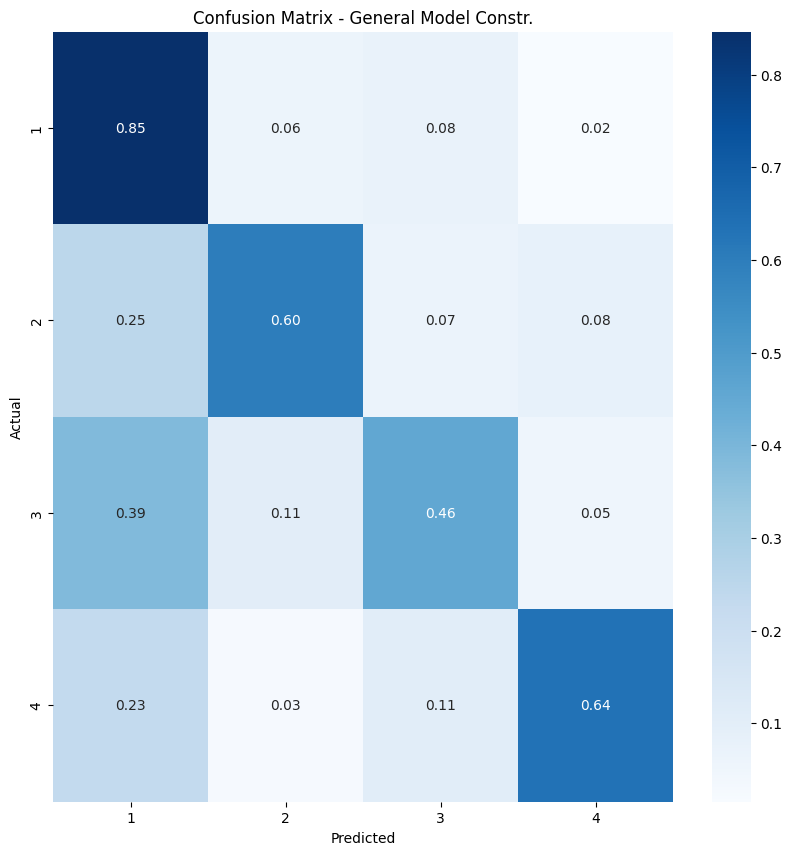

In [44]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

# Import the best Classifier model
model_path = best_model
input_dim = batch[0].shape[-1]
checkpoint_model = ClassifierPerTask_Approach4.load_from_checkpoint(model_path, enable_wandb=False)

checkpoint_model.eval()

# Get the predictions
y_true = []
y_pred = []
for batch in test_loader:
    inputs, labels = batch
    inputs = inputs.to(torch.float32)
    z = checkpoint_model.encoder(inputs)
    outputs = checkpoint_model(z)
    preds = torch.argmax(outputs, dim=1)
    y_true.extend(labels)
    y_pred.extend(preds)

y_true = [label2idx[item] for item in y_true]
y_pred = [item.item() for item in y_pred]

plot_confusion_matrix(y_true, y_pred, labels_task, "Confusion Matrix - General Model Constr.")




## Contrastive + Meta Learning

In [ ]:
# First create a mapping utility to go from label to idx and vice versa
label2idx= {}
idx2label = {}
labels_task = dataset.get_dataframe()['labels'].unique()

for i in range(len(labels_task)):
  label2idx[labels_task[i]] = i
  idx2label[str(i)] = labels_task[i]

def compute_prototypes(support, labels, fallback_prototypes, missing_labels=None):
    classes = torch.unique(labels)
    # Concatenate the missing labels to the classes and sort them
    if missing_labels is not None:
        classes = torch.cat((classes, torch.tensor(missing_labels)))
        classes = torch.sort(classes)[0]

    prototypes = torch.zeros(
        classes.size(0),
        *support.shape[1:],
        device=support.device,
        dtype=support.dtype,
    )
    for i, cls in enumerate(classes):
        # First you check if cls exist in the labels
        if cls in labels:
            embeddings = support[labels == cls]
            prototypes[i].add_(embeddings.mean(dim=0))
        else:
            # RETIREVE THE MISSING CLASS FROM THE PRECOMPUTED PROTOTYPES
            # embeddings = fallback_prototypes[ cls ]
            # print(f"{cls} not found in the batch, using precomputed prototype of shape {embeddings.shape}")
            embeddings = torch.zeros(support.shape[1])
            prototypes[i].add_(embeddings)

            prototypes[i].add_(embeddings)

    return prototypes #(classes, h_dim)

def accuracy(preds, targets):
    """Computes accuracy"""
    acc = (preds.argmax(dim=1).long() == targets.long()).sum().float()
    return acc / preds.size(0)

class PrototypicalClassifier(torch.nn.Module):
    def __init__( self,support=None,labels=None,fallback_prototypes=None, distance="euclidean",normalize=False):
      super(PrototypicalClassifier, self).__init__()
      self.distance_metric = distance
      self.normalize = normalize

      # Select compute_prototypes function
      self._compute_prototypes = compute_prototypes

      # Assign distance function
      if distance == "euclidean":
        print("Using euclidean distance as distance metric")
        self.distance = PrototypicalClassifier.euclidean_distance
      elif distance == "cosine":
        print("Using cosine distance as distance metric")
        self.distance = PrototypicalClassifier.cosine_distance
        self.normalize = True
      else:
        print("Using custom distance function as distance metric")
        self.distance = distance

      # Compute prototypes
      self.prototypes = None
      if support is not None and labels is not None:
          self.fit_(support, labels)
      if fallback_prototypes is not None:
          self.fallback_prototypes = fallback_prototypes # We set the precomputed prototypes as fallback: when a batch doesn't contain a class, we use the precomputed prototype
          print(f"INFO: Using precomputed prototypes of shape {self.fallback_prototypes.shape}")

    @staticmethod
    def euclidean_distance(prototypes, queries):
      '''
      - prototype is the tensor => [n_prot , hidden_dim] that contains the mean tensor for (presumibly) each class
      - queries are the samples that have to be classified => [bs, hidden_dim]
      '''
      n = prototypes.size(0)
      m = queries.size(0)
      # The numb_of_protototypes represents the number of classes that have been selected in the current generation of prototypes
      prototypes = prototypes.unsqueeze(0).expand(m, n, -1) #[ bs, numb_of_protototypes, h_dim]
      queries = queries.unsqueeze(1).expand(m, n, -1) #[ bs, numb_of_protototypes, h_dim]
      distance = (prototypes - queries).pow(2).sum(dim=-1)
      # print(f"Distance shape => {distance.shape} , TENSOR => {distance}")

      return distance


    @staticmethod
    def cosine_distance(prototypes, queries):
        # Assumes prototypes and queries are normalized
        return -queries @ prototypes.t()

    @staticmethod
    def normalize(x, epsilon=1e-8):
        x = x / (x.norm(p=2, dim=-1, keepdim=True) + epsilon)
        return x

    def fit_(self, support, labels, missing_labels=None):
        """
        **Description**

        Computes and updates the prototypes given support embeddings and
        corresponding labels.

        **Arguments**
        missing_labels: list of missing labels (might be None if all labels are present and it is possible to compute the prototypes)
        """
        # TODO: Make a differentiable version? (For Proto-MAML style algorithms)

        # Compute new prototypes
        prototypes = self._compute_prototypes(support, labels, self.fallback_prototypes, missing_labels)

        # Normalize if necessary
        if self.normalize:
            prototypes = PrototypicalClassifier.normalize(prototypes)

        # Assign prototypes and return them
        self.prototypes = prototypes
        return prototypes

    def forward(self, x):
        assert (
            self.prototypes is not None
        ), "Prototypes not computed, use compute_prototypes(support, labels)"
        if self.normalize:
            x = PrototypicalClassifier.normalize(x)
        return -self.distance(self.prototypes, x)

class PrototypicalNetwork(LightningModule):
    # https://github.com/learnables/learn2learn/blob/master/learn2learn/algorithms/lightning/lightning_protonet.py#L97
    # https://github.com/learnables/learn2learn/blob/master/learn2learn/nn/protonet.py#L57
    # https://github.com/learnables/learn2learn/blob/master/learn2learn/algorithms/lightning/lightning_episodic_module.py
    def __init__(self, encoder, text_labels, train_dataset_split, distance_metric = "euclidean",run_name ="run_1", enable_wandb=False):
      super(PrototypicalNetwork, self).__init__()
      self.save_hyperparameters()

      self.encoder = encoder
      self.text_labels = text_labels
      self.idx_labels = [label2idx[label] for label in text_labels]
      self.train_dataset_split = train_dataset_split # Create an internal access to the train split

      self.train_loss = []
      self.train_accuracy = []
      self.val_loss = []
      self.val_accuracy = []
      self.test_loss = []
      self.test_accuracy = []
      self.best_val_acc = 0.0

      self.distance_metric = distance_metric
      # Precompute the prototypes to ensure that exist one prototype for each class
      self.classifier = PrototypicalClassifier(fallback_prototypes=self.precompute_prototypes(), distance=self.distance_metric)
      self.lr = 0.001
      self.scheduler_step = 20
      self.scheduler_decay = 1.0

      self.enable_wandb = enable_wandb
      self.loss = nn.CrossEntropyLoss(reduction="mean")
      self.run_name = run_name

      if self.enable_wandb:
        wandb.init(project="Project_EAI_BrainComputerInterface", entity="rucci-2053183", group="approach3",name=run_name)

    def precompute_prototypes(self):
      # For each class in the text_labels, select 10 random samples from the train_dataset_split with the corresponding label
      # make those samples pass through the encoder and compute the mean of the embeddings
      # return the prototypes in the form #[classes, h_dim]
      # Just consider that the train_dataset_split contains the samples as a tuple (data, label)
      prototypes = []
      for label in self.text_labels:
        samples = [sample[0] for sample in self.train_dataset_split if sample[1] == label]
        samples = [sample.to(torch.float32) for sample in samples]
        samples = torch.stack(samples)
        embeddings = self.encoder(samples)
        # embeddings do not require the gradient and they shouldn't be in the computation graph
        embeddings = embeddings.detach()
        prototypes.append(embeddings.mean(dim=0))

      return torch.stack(prototypes)

    def forward(self, z):
      logits = self.classifier(z)
      return logits

    def labels2TargetTensor(self, labels):
      target = []
      for item in labels:
        target.append(label2idx[item])

      return torch.Tensor(target)

    def get_count_class_samples(self,labels):
      classes = torch.unique(labels)
      class_samples = {}
      for cls in classes:
        num_samples = torch.sum(labels == cls).item()
        class_samples[cls.item()] = num_samples

      # Find the class with the minimum number of samples
      min_samples_class = min(class_samples, key=class_samples.get)

      # Convert the min_samples_class to a dictionary with the label as the key
      min_samples_class_dict = {min_samples_class: class_samples[min_samples_class]}

      return class_samples, min_samples_class_dict


    def training_step(self, batch, batch_idx):
      data, labels = batch # (bs,input_dim)
      labels = self.labels2TargetTensor(labels).to(torch.long)
      data = data.to(torch.float32)

      batch_stats, min_samples_class = self.get_count_class_samples(labels)


      # Sort data samples by labels
      sort = torch.sort(labels)
      data = data.squeeze(0)[sort.indices].squeeze(0)
      labels = labels.squeeze(0)[sort.indices].squeeze(0)


      # Initialize support indices
      support_indices = np.zeros(data.size(0), dtype=bool) # (bs, true when the sample is in the support set, false when is a query sample)

      # for each class in the batch, select the first n random samples as support set for that class and the rest as query, and report that in the support_indices
      for _cls in list(batch_stats.keys()):
        sample_for_class = batch_stats[_cls]
        if sample_for_class > 1:
          n =  random.randint(1, int(sample_for_class * 0.3)+1) # Randomly select the first n samples as support set (n is minimum 1 and maximum the 10% of the sample_for_clas)
          class_indices = (labels == _cls).nonzero()  # Indices of samples belonging to the current class
          support_indices[class_indices[:n]] = True  # Mark the first 'n' elements for the current class as support


      # Compute support and query embeddings
      embeddings = self.encoder(data) # [bs, encoder.z_dim]

      # Select the support and query samples from the embeddings
      support = embeddings[support_indices]
      support_labels = labels[support_indices]

      # support_label is in the form of [0,0,0,1,1,1,2,2,2,3,3,3,4,4,4] where each number represents a class;
      # Giving that in the variable self.idx_labels we have a list that contains all the classes of the task
      # We have to identify which label is missing from the support_label: consider the unique(support_labels), then check that all the labels in self.idx_labels are present in the unique(support_labels)
      # If a label is missing, then we have to add it to the unique(support_labels) and create a prototype with the right function
      missing_labels = list(set(self.idx_labels) - set(torch.unique(support_labels).tolist()))

      if len(missing_labels) > 0:
        # Add the missing labels to the support_labels
        # support_labels = torch.cat((support_labels, torch.tensor(missing_labels).to(support_labels.device)))
        # Compute the prototypes with the new support_labels
        self.classifier.fit_(support, support_labels, missing_labels=missing_labels) # a list of missing labels [13, 12, 5]
      else:
        self.classifier.fit_(support, support_labels)

      logits = self.classifier(embeddings)
      loss = F.cross_entropy(logits, labels)
      acc = accuracy(logits, labels)


      self.log('train_loss', loss)
      self.train_loss.append(loss)
      self.train_accuracy.append(acc)

      return loss

    def on_train_epoch_end(self):
      train_loss = torch.stack([x for x in self.train_loss]).mean()
      train_acc = torch.stack([x for x in self.train_accuracy]).mean()

      # Print the training loss
      print_log = f'Training - Epoch {self.current_epoch}: Loss => {train_loss.item()} ACCURACY => {train_acc}'

      self.train_loss.clear()
      self.train_accuracy.clear()

      # Every 10 epochs, compute again the fallback_prototypes
      if self.current_epoch % 10 == 0:
        self.classifier.fallback_prototypes = self.precompute_prototypes()
        print(f"Prototypes recomputed at epoch {self.current_epoch}")

      # Every 20 epochs save in a file the prototypes and call the file with the epoch number
      if self.current_epoch % 20 == 0:
        # Create a folder to save the prototypes if it doesn't exist MyDrive/ColabNotebooks/EAI_Napoli/saved_models/Approach_3/{self.run_name}/saved_prototypes/
        # avoid in any case the error "Parent directory /content/mydrive/MyDrive/ColabNotebooks/EAI_Napoli/saved_models/Approach_3/run_1/saved_prototypes does not exist."
        os.makedirs(f"saved_models/Approach_3_FeaturesDataset/{self.run_name}/saved_prototypes/", exist_ok=True)

        torch.save(self.classifier.fallback_prototypes, f"saved_models/Approach_3_FeaturesDataset/{self.run_name}/saved_prototypes/prototypes_epoch_{self.current_epoch}.pt")
        print(f"Prototypes saved at epoch {self.current_epoch}")

      if self.enable_wandb:
          # Log mean training loss
          wandb.log({"epoch_train_loss": train_loss, "epoch_train_accuracy": train_acc})

      if self.current_epoch % 10 == 0:
        print(print_log)

    def validation_step(self, batch, batch_idx):
        # Same logic as the training step
        data, labels = batch
        labels = self.labels2TargetTensor(labels).to(torch.long)
        data = data.to(torch.float32)

        batch_stats, min_samples_class = self.get_count_class_samples(labels)

        # Sort data samples by labels
        sort = torch.sort(labels)
        data = data.squeeze(0)[sort.indices].squeeze(0)
        labels = labels.squeeze(0)[sort.indices].squeeze(0)

        # Initialize support indices
        support_indices = np.zeros(data.size(0), dtype=bool) # (bs, true when the sample is in the support set, false when is a query sample)

        # for each class in the batch, select the first n random samples as support set for that class and the rest as query, and report that in the support_indices
        for _cls in list(batch_stats.keys()):
          sample_for_class = batch_stats[_cls]
          if sample_for_class > 1:
            # Randomly select the first n samples as support set (n is minimum 1 and maximum the 10% of the sample_for_clas)
            n =  random.randint(1, int(sample_for_class * 0.3)+1)
            class_indices = (labels == _cls).nonzero()
            support_indices[class_indices[:n]] = True


        # Compute support and query embeddings
        embeddings = self.encoder(data)

        # Select the support and query samples from the embeddings
        support = embeddings[support_indices]
        support_labels = labels[support_indices]

        missing_labels = list(set(self.idx_labels) - set(torch.unique(support_labels).tolist()))

        if len(missing_labels) > 0:
          # Add the missing labels to the support_labels
          # support_labels = torch.cat((support_labels, torch.tensor(missing_labels).to(support_labels.device)))
          # Compute the prototypes with the new support_labels
          proto = self.classifier.fit_(support, support_labels, missing_labels=missing_labels)
        else:
          proto = self.classifier.fit_(support, support_labels)

        logits = self.classifier(embeddings)
        loss = F.cross_entropy(logits, labels)
        acc = accuracy(logits, labels)

        self.log('val_loss', loss)
        self.log('val_accuracy', acc)
        self.val_loss.append(loss)
        self.val_accuracy.append(acc)

        return loss

    def on_validation_epoch_end(self):
        val_loss = torch.stack([x for x in self.val_loss]).mean()
        val_acc = torch.stack([x for x in self.val_accuracy]).mean()

        # Print the training loss
        print_log = f'Validation - Epoch {self.current_epoch}: Loss => {val_loss.item()} ACCURACY => {val_acc}'

        self.val_loss.clear()
        self.val_accuracy.clear()

        self.log('epoch_val_loss', val_loss)
        self.log('epoch_val_accuracy', val_acc)

        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            # Save the fallback_prototypes
            print(f"Saving new prototypes that yield to the new (VAL) best accuracy: {self.best_val_acc} at epoch {self.current_epoch}")
            os.makedirs(f"saved_models/Approach_3_FeaturesDataset/{self.run_name}/saved_prototypes/", exist_ok=True)
            torch.save(self.classifier.fallback_prototypes, f"saved_models/Approach_3_FeaturesDataset/{self.run_name}/saved_prototypes/BEST_prototypes.pt")

        if self.enable_wandb:
            # Log mean val loss
            wandb.log({"epoch_val_loss": val_loss, "epoch_val_accuracy": val_acc})

        if self.current_epoch % 10 == 0:
          print(print_log)

    def test_step(self, batch, batch_idx):
      # Same logic as the training step
      data, labels = batch
      labels = self.labels2TargetTensor(labels).to(torch.long)
      data = data.to(torch.float32)

      batch_stats, min_samples_class = self.get_count_class_samples(labels)

      # Sort data samples by labels
      sort = torch.sort(labels)
      data = data.squeeze(0)[sort.indices].squeeze(0)
      labels = labels.squeeze(0)[sort.indices].squeeze(0)

      # It Is ok to use the same logic of the training and validation step becouse even if i'm using
      # the test set samples to create the support set, this is equivalent of using any other set of samples

      # Initialize support indices
      support_indices = np.zeros(data.size(0), dtype=bool)

      for _cls in list(batch_stats.keys()):
        sample_for_class = batch_stats[_cls]
        if sample_for_class > 1:
          n =  random.randint(1, int(sample_for_class * 0.3)+1)
          class_indices = (labels == _cls).nonzero()
          support_indices[class_indices[:n]] = True

      # Compute support and query embeddings
      embeddings = self.encoder(data)
      # Select the support and query samples from the embeddings
      support = embeddings[support_indices]
      support_labels = labels[support_indices]

      missing_labels = list(set(self.idx_labels) - set(torch.unique(support_labels).tolist()))

      if len(missing_labels) > 0:
        self.classifier.fit_(support, support_labels, missing_labels=missing_labels)
      else:
        self.classifier.fit_(support, support_labels)

      logits = self.classifier(embeddings)
      loss = F.cross_entropy(logits, labels)
      acc = accuracy(logits, labels)

      self.log('test_loss', loss)
      self.test_loss.append(loss)
      self.log('test_accuracy', acc)
      self.test_accuracy.append(acc)

      return loss

    def on_test_epoch_end(self):
      test_loss = torch.stack([x for x in self.test_loss]).mean()
      test_acc = torch.stack([x for x in self.test_accuracy]).mean()

      # Print the training loss
      print_log = f'Test - Epoch {self.current_epoch}: Loss => {test_loss.item()} ACCURACY => {test_acc}'

      self.test_loss.clear()
      self.test_accuracy.clear()

      if self.enable_wandb:
          # Log mean test loss
          wandb.log({"epoch_test_loss": test_loss, "epoch_test_accuracy": test_acc})

      print(print_log)

    def configure_optimizers(self):
      optimizer = optim.Adam(self.parameters(), lr=self.lr)
      lr_scheduler = optim.lr_scheduler.StepLR(
          optimizer,
          step_size=self.scheduler_step,
          gamma=self.scheduler_decay,
      )
      return [optimizer], [lr_scheduler]

In [24]:
# Train the classifier using the contrastive pretrained autoencoder
batch_size = 256
train_dataset = DataFrameApproach4(train_df)
val_dataset = DataFrameApproach4(val_df)
test_dataset = DataFrameApproach4(test_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)


batch = next(iter(train_loader))
input_dim = batch[0].shape[-1]

#Initialize the autoencoder from scratch becouse it didnt converge the from scratch training
checkpoint_autoencoder = Autoencoder(input_dim=input_dim, batch_size=batch_size, sparsity_factor=0.005, enable_sparsity_loss=False, enable_weight_decay_loss=False, enable_non_negativity_constraint=False, enable_wandb=False, decoder_none=True)


checkpoint_model = ConstrastiveLearner(encoder=checkpoint_autoencoder.encoder, enable_wandb=False, input_dim=input_dim)

encoder = checkpoint_autoencoder.encoder  # Fixed reference to checkpoint_autoencoder
encoder.z_dim = 128
classifier = PrototypicalNetwork(encoder, dataset_labels, train_dataset, distance_metric="euclidean", run_name="run_metalearning_ae_feats_dataset", enable_wandb=True)

# 300 Epochs patience early stopping with min delta of 0.001 over the epoch_val_accuracy
early_stop_callback = EarlyStopping(
    monitor='epoch_val_accuracy',
    min_delta=0.001,
    patience=300,
    verbose=True,
    mode='max',
    check_on_train_epoch_end=False
)

# Model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    monitor='epoch_val_accuracy',
    dirpath="saved_models/Approach_4_FeaturesDataset/meta_learning",
    filename="BEST_{epoch}",
    save_top_k=1,
    mode='max',
)

trainer_classifier = Trainer(max_epochs=10000, default_root_dir="saved_models/Approach_4_FeaturesDataset/meta_learning", callbacks=[early_stop_callback, checkpoint_callback], fast_dev_run=False)
trainer_classifier.fit(classifier, train_loader, val_loader)

# Evaluate
trainer_classifier.test(classifier, test_loader)


Using device: cpu
Using device: cpu
Initialized Model on cpu
Using euclidean distance as distance metric
INFO: Using precomputed prototypes of shape torch.Size([4, 128])


/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: saved_models/Approach_4_FeaturesDataset/meta_learning/lightning_logs
/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/saved_models/Approach_4_FeaturesDataset/meta_learning exists and is not empty.

  | Name       | Type                   | Params
------------------------------------------------------
0 | encoder    | Encoder                | 51.8 K
1 | classifier | PrototypicalClassifier | 0     
2 | loss       | CrossEntropyLoss       | 0     
------------------------------------------------------
51.8 K    Trainable params
0         Non-trainable params
51.8 K    Total params
0.207     Total estimated model params size (MB)


/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:104: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.
/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/emanuelerucci/Desktop/Sapienza/Ma

Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 46.44it/s, v_num=0]Prototypes recomputed at epoch 0
Prototypes saved at epoch 0
Training - Epoch 0: Loss => 27.750696182250977 ACCURACY => 0.37421876192092896
Epoch 1:  20%|██        | 1/5 [00:00<00:00, 55.45it/s, v_num=0]

/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:383: `ModelCheckpoint(monitor='epoch_val_accuracy')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('epoch_val_accuracy', value)` in the `LightningModule`?


Epoch 10: 100%|██████████| 5/5 [00:00<00:00, 32.21it/s, v_num=0]Prototypes recomputed at epoch 10
Training - Epoch 10: Loss => 12.441949844360352 ACCURACY => 0.4828124940395355
Epoch 20: 100%|██████████| 5/5 [00:00<00:00, 53.92it/s, v_num=0]Prototypes recomputed at epoch 20
Prototypes saved at epoch 20
Training - Epoch 20: Loss => 8.05703353881836 ACCURACY => 0.5015624761581421
Epoch 30: 100%|██████████| 5/5 [00:00<00:00, 57.17it/s, v_num=0]Prototypes recomputed at epoch 30
Training - Epoch 30: Loss => 13.841728210449219 ACCURACY => 0.4375
Epoch 40: 100%|██████████| 5/5 [00:00<00:00, 56.92it/s, v_num=0]Prototypes recomputed at epoch 40
Prototypes saved at epoch 40
Training - Epoch 40: Loss => 11.197107315063477 ACCURACY => 0.46562498807907104
Epoch 50: 100%|██████████| 5/5 [00:00<00:00, 54.10it/s, v_num=0]Prototypes recomputed at epoch 50
Training - Epoch 50: Loss => 7.07266092300415 ACCURACY => 0.500781238079071
Epoch 60: 100%|██████████| 5/5 [00:00<00:00, 55.04it/s, v_num=0]Prototype

/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.37it/s]

/Users/emanuelerucci/Desktop/Sapienza/Materie/EAI_Napoli/Progetto/.conda/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 256. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Test - Epoch 899: Loss => 1.1331701278686523 ACCURACY => 0.578125
Testing DataLoader 0: 100%|██████████| 1/1 [00:04<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy              0.578125
        test_loss           1.1331701278686523
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.1331701278686523, 'test_accuracy': 0.578125}]

In [25]:
wandb.finish()

epoch_test_accuracy,▁
epoch_test_loss,▁
epoch_train_accuracy,▁▂▃▃▂▃▅▃▃▅▄▅▅▅▄▅▄▅▅▆▄▆▆▅▆▇▇▆▆▇▆▆▆▇▇███▇█
epoch_train_loss,█▇▆▇▄▅▄▄█▂▃▃▃▂▂▂▂▃▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_test_accuracy,0.57812
epoch_test_loss,1.13317
epoch_train_accuracy,0.77734
epoch_train_loss,0.66275
